In [64]:
import pprint, copy
import numpy as NP
import numpy.ma as MA
import matplotlib.pyplot as PLT
from matplotlib.patches import Circle, Wedge, Polygon
import yaml, argparse, warnings
import astropy.units as U
import astropy.cosmology as cosmology
import astropy.constants as FCNST
import astropy.cosmology as cosmology
import scipy.signal as SPS
import prisim
from prisim import interferometry as RI
from prisim import bispectrum_phase as BSP
from prisim import delay_spectrum as DS

from IPython.core.debugger import set_trace
%matplotlib inline

### Print PRISim version

In [2]:
print('PRISim git # {0}'.format(prisim.__githash__))

PRISim git # b3cbcecd46b74bd338ca236ba7a196ff4883e98a


## Set up Cosmological parameters

In [3]:
cosmoPlanck15 = cosmology.Planck15 # Planck 2015 cosmology
cosmo100 = cosmoPlanck15.clone(name='Modified Planck 2015 cosmology with h=1.0', H0=100.0) # Modified Planck 2015 cosmology with h=1.0, H= 100 km/s/Mpc

## Set up input/output directories

In [4]:
bspdir = '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/bispectrum_phase/'
figdir = bspdir + 'figures/'

In [5]:
freq_window_centers = NP.asarray([150e6])
freq_window_bw = NP.asarray([42e6])
freq_window_shape = 'bhw'
freq_window_fftpow = 2
pad = 7.0

print('freq window centers = ', freq_window_centers)
print('freq window BW eff = ', freq_window_bw)
print('freq window shape = '+freq_window_shape)
print('freq window fftpow = {0:.1f}'.format(freq_window_fftpow))
print('pad = {0:.1f}'.format(pad))

('freq window centers = ', array([1.5e+08]))
('freq window BW eff = ', array([42000000.]))
freq window shape = bhw
freq window fftpow = 2.0
pad = 7.0


## Set up cases with Foregrounds and HI

In [6]:
case_with_FG_HI = {'1ps_FG_no_spindex_HI_colocated': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_no_spindex_HI_cosine_colocated/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                                      'bspfile_sfx': '_HERA19_1ps_FG_no_spindex_HI_cosine_colocated_chromatic_AiryBeam_noiseless.hdf5'}, 
                   '1ps_FG_spindex_HI_colocated': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex_HI_cosine_colocated/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                                   'bspfile_sfx': '_HERA19_1ps_FG_spindex_HI_cosine_colocated_chromatic_AiryBeam_noiseless.hdf5'},   
                   '1ps_FG_no_spindex_HI_displaced': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_no_spindex_HI_cosine_displaced/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                                      'bspfile_sfx': '_HERA19_1ps_FG_no_spindex_HI_cosine_displaced_chromatic_AiryBeam_noiseless.hdf5'},
                   '1ps_FG_spindex_HI_displaced': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex_HI_cosine_displaced/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                                   'bspfile_sfx': '_HERA19_1ps_FG_spindex_HI_cosine_displaced_chromatic_AiryBeam_noiseless.hdf5'},
                   'GLEAM_1ps_HI': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/toy_GLEAM_1ps_HI_cosine/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                    'bspfile_sfx': '_HERA19_GLEAM_FG_FoV-30_HI_cosine_on_zenith_chromatic_AiryBeam_noiseless.hdf5'},
                   'GLEAM_HI_21cmfast': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/toy_GLEAM_HI_21cmfast_FaintGalaxies_fiducial_FoV-30/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                         'bspfile_sfx': '_HERA19_GLEAM_FG_FoV-30_HI_21cmfast_FaintGalaxies_fiducial_chromatic_AiryBeam_noiseless.hdf5'},
                   '1ps_FG_no_spindex_HI_21cmfast': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_no_spindex_on_zenith_toy_HI_21cmfast_FaintGalaxies_fiducial/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                                     'bspfile_sfx': '_HERA19_1ps_FG_no_spindex_on_zenith_HI_21cmfast_FaintGalaxies_fiducial_chromatic_AiryBeam_noiseless.hdf5'},
                   '1ps_FG_spindex_HI_21cmfast': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex_on_zenith_toy_HI_21cmfast_FaintGalaxies_fiducial/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                                  'bspfile_sfx': '_HERA19_1ps_FG_no_spindex_on_zenith_HI_21cmfast_FaintGalaxies_fiducial_chromatic_AiryBeam_noiseless.hdf5'}
                  }

In [7]:
key_mapping_FG_HI = {'1ps_FG_no_spindex_HI_colocated': {'FG': '1ps_FG_no_spindex_on_zenith', 
                                                        'HI': '1ps_HI_cosine'}, 
                     '1ps_FG_spindex_HI_colocated': {'FG': '1ps_FG_spindex_on_zenith', 
                                                     'HI': '1ps_HI_cosine'}, 
                     '1ps_FG_no_spindex_HI_displaced': {'FG': '1ps_FG_no_spindex_off_zenith', 
                                                        'HI': '1ps_HI_cosine'}, 
                     '1ps_FG_spindex_HI_displaced': {'FG': '1ps_FG_spindex_off_zenith', 
                                                     'HI': '1ps_HI_cosine'},
                     'GLEAM_1ps_HI': {'FG': 'GLEAM', 
                                      'HI': '1ps_HI_cosine'},
                     'GLEAM_HI_21cmfast': {'FG': 'GLEAM', 
                                           'HI': 'HI_21cmfast_fiducial'},
                     '1ps_FG_no_spindex_HI_21cmfast': {'FG': '1ps_FG_no_spindex_on_zenith', 
                                                       'HI': 'HI_21cmfast_fiducial'},
                     '1ps_FG_spindex_HI_21cmfast': {'FG': '1ps_FG_spindex_on_zenith', 
                                                    'HI': 'HI_21cmfast_fiducial'}
                    }

## Set up cases with Foregrounds only

In [8]:
case_with_FG = {'1ps_FG_no_spindex_on_zenith': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_no_spindex/on_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                                'bspfile_sfx': '_HERA19_1ps_FG_no_spindex_on_zenith_chromatic_AiryBeam_noiseless.hdf5'},
                '1ps_FG_no_spindex_off_zenith': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_no_spindex/off_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                                 'bspfile_sfx': '_HERA19_1ps_FG_no_spindex_off_zenith_chromatic_AiryBeam_noiseless.hdf5'},
                '1ps_FG_spindex_on_zenith': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex/on_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                             'bspfile_sfx': '_HERA19_1ps_FG_spindex_on_zenith_chromatic_AiryBeam_noiseless.hdf5'},
                '1ps_FG_spindex_off_zenith': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex/off_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                                              'bspfile_sfx': '_HERA19_1ps_FG_spindex_off_zenith_chromatic_AiryBeam_noiseless.hdf5'},
                'GLEAM': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/toy_GLEAM_FoV-30/on_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/', 
                          'bspfile_sfx': '_HERA19_GLEAM_FG_FoV-30_chromatic_AiryBeam_noiseless.hdf5'}
               }

## Set up cases with HI only

In [9]:
case_with_HI = {'1ps_HI_cosine': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_HI_cosine/on_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/'},
                'HI_21cmfast_fiducial': {'visdir': '/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/toy_HI_21cmfast_FaintGalaxies_fiducial/on_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/'}
               }

## Load visibilities of cases with Foregorunds only

In [10]:
for case_id in case_with_FG:
    print('\nLoading visibilities for case: {0}\n\t\t\t from: {1}'.format(case_id, case_with_FG[case_id]['visdir']))
    case_with_FG[case_id]['vis'] = RI.InterferometerArray(None, None, None, init_file=case_with_FG[case_id]['visdir']+'simvis')
#     # Perform minor astrometric corrections when the point source foreground is supposed to be at zenith but is not
#     if 'on_zenith' in case_id:
#         print('\tPerforming minor astrometric corrections...')
#         case_with_FG[case_id]['vis'].skyvis_freq[:,:,0].real = NP.abs(case_with_FG[case_id]['vis'].skyvis_freq[:,:,0])
#         case_with_FG[case_id]['vis'].skyvis_freq[:,:,0].imag = NP.zeros_like(case_with_FG[case_id]['vis'].skyvis_freq[:,:,0].real)
#         case_with_FG[case_id]['vis'].vis_freq = case_with_FG[case_id]['vis'].skyvis_freq + case_with_FG[case_id]['vis'].vis_noise_freq
    print('Loaded!\n----------')


Loading visibilities for case: 1ps_FG_no_spindex_off_zenith
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_no_spindex/off_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/
Loaded!
----------

Loading visibilities for case: 1ps_FG_spindex_off_zenith
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex/off_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/
Loaded!
----------

Loading visibilities for case: 1ps_FG_no_spindex_on_zenith
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_no_spindex/on_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/
Loaded!
----------

Loading visibilities for case: 1ps_FG_spindex_on_zenith
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex/on_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7

## Load visibilities of cases with HI only

In [11]:
for case_id in case_with_HI:
    print('\nLoading visibilities for case: {0}\n\t\t\t from: {1}'.format(case_id, case_with_HI[case_id]['visdir']))
    case_with_HI[case_id]['vis'] = RI.InterferometerArray(None, None, None, init_file=case_with_HI[case_id]['visdir']+'simvis')
#     # Perform minor astrometric corrections when the point source foreground is supposed to be at zenith but is not
#     if '1ps' in case_id:
#         print('\tPerforming minor astrometric corrections...')
#         case_with_HI[case_id]['vis'].skyvis_freq[:,:,0].real = NP.abs(case_with_HI[case_id]['vis'].skyvis_freq[:,:,0])
#         case_with_HI[case_id]['vis'].skyvis_freq[:,:,0].imag = NP.zeros_like(case_with_HI[case_id]['vis'].skyvis_freq[:,:,0].real)
#         case_with_HI[case_id]['vis'].vis_freq = case_with_HI[case_id]['vis'].skyvis_freq + case_with_HI[case_id]['vis'].vis_noise_freq
    print('Loaded!\n----------')


Loading visibilities for case: 1ps_HI_cosine
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_HI_cosine/on_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/
Loaded!
----------

Loading visibilities for case: HI_21cmfast_fiducial
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/toy_HI_21cmfast_FaintGalaxies_fiducial/on_zenith_HERA19/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/
Loaded!
----------


## Load visibilities of cases with Foregorunds and HI

In [12]:
for case_id in case_with_FG_HI:
    print('\nLoading visibilities for case: {0}\n\t\t\t from: {1}'.format(case_id, case_with_FG_HI[case_id]['visdir']))
    case_with_FG_HI[case_id]['vis'] = RI.InterferometerArray(None, None, None, init_file=case_with_FG_HI[case_id]['visdir']+'simvis')
    if ('on_zenith' in key_mapping_FG_HI[case_id]['FG']) or ('1ps' in key_mapping_FG_HI[case_id]['HI']):
        case_with_FG_HI[case_id]['vis'].skyvis_freq = case_with_FG[key_mapping_FG_HI[case_id]['FG']]['vis'].skyvis_freq + case_with_HI[key_mapping_FG_HI[case_id]['HI']]['vis'].skyvis_freq
        case_with_FG_HI[case_id]['vis'].vis_freq = case_with_FG_HI[case_id]['vis'].skyvis_freq + case_with_FG_HI[case_id]['vis'].vis_noise_freq
    print('Loaded!\n----------')


Loading visibilities for case: 1ps_FG_no_spindex_HI_colocated
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_no_spindex_HI_cosine_colocated/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/
Loaded!
----------

Loading visibilities for case: 1ps_FG_spindex_HI_displaced
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex_HI_cosine_displaced/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/
Loaded!
----------

Loading visibilities for case: 1ps_FG_spindex_HI_21cmfast
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex_on_zenith_toy_HI_21cmfast_FaintGalaxies_fiducial/chromatic_AiryBeam_2x60.0sec_1024x97.7kHz/simdata/
Loaded!
----------

Loading visibilities for case: 1ps_FG_spindex_HI_colocated
			 from: /lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/visibilities/1ps_FG_spindex_HI_cosine_coloca

In [13]:
print(case_with_FG['1ps_FG_no_spindex_on_zenith']['vis'].skyvis_freq.shape)
print(case_with_FG['1ps_FG_no_spindex_on_zenith']['vis'].skyvis_freq[[0,1,2],:,0])
print(NP.abs(case_with_FG['1ps_FG_no_spindex_on_zenith']['vis'].skyvis_freq[[0,1,2],:,0].imag).max())

print(case_with_HI['1ps_HI_cosine']['vis'].skyvis_freq.shape)
print(case_with_HI['1ps_HI_cosine']['vis'].skyvis_freq[[0,1,2],:,0])
print(NP.abs(case_with_HI['1ps_HI_cosine']['vis'].skyvis_freq[[0,1,2],:,0].imag).max())

(30, 1024, 2)
[[99.99988848-0.1412889j  99.99988826-0.14142688j 99.99988804-0.14156486j
  ... 99.99955523-0.28216349j 99.99955479-0.28230147j
  99.99955436-0.28243945j]
 [99.99994947-0.08812331j 99.99994937-0.08820937j 99.99994927-0.08829542j
  ... 99.99979845-0.17598831j 99.99979826-0.17607437j
  99.99979806-0.17616043j]
 [99.99997416-0.05316563j 99.99997411-0.05321755j 99.99997406-0.05326947j
  ... 99.99989695-0.10617545j 99.99989684-0.10622737j
  99.99989674-0.10627929j]]
0.282439448407826
(30, 1024, 2)
[[ 0.00999999-1.41288903e-05j  0.00817584-1.15628470e-05j
   0.00336889-4.76917642e-06j ... -0.00266712+7.52566038e-06j
   0.00336888-9.51045014e-06j  0.00817581-2.30918204e-05j]
 [ 0.00999999-8.81233079e-06j  0.00817584-7.21186378e-06j
   0.0033689 -2.97458323e-06j ... -0.00266712+4.69383281e-06j
   0.00336889-5.93176687e-06j  0.00817583-1.44026090e-05j]
 [ 0.01      -5.31656285e-06j  0.00817585-4.35098590e-06j
   0.0033689 -1.79459431e-06j ... -0.00266712+2.83183460e-06j
   0.00336

In [14]:
case_id = case_with_HI.keys()[0]

freqs = case_with_HI[case_id]['vis'].channels
antlocs = case_with_HI[case_id]['vis'].layout['positions']
antlabels = case_with_HI[case_id]['vis'].layout['labels']
baselines = case_with_HI[case_id]['vis'].baselines
baseline_labels = case_with_HI[case_id]['vis'].labels

print('Antenna Info:')
pprint.pprint(zip(antlabels, antlocs))
print('--------------')
print('Baseline info:')
pprint.pprint(zip(baseline_labels, baselines))

Antenna Info:
[('0', array([-21.9      ,  12.6439709,   0.       ])),
 ('1', array([-7.3      , 12.6439709,  0.       ])),
 ('2', array([ 7.3      , 12.6439709,  0.       ])),
 ('3', array([21.9      , 12.6439709,  0.       ])),
 ('4', array([-21.9      , -12.6439709,   0.       ])),
 ('5', array([ -7.3      , -12.6439709,   0.       ])),
 ('6', array([  7.3      , -12.6439709,   0.       ])),
 ('7', array([ 21.9      , -12.6439709,   0.       ])),
 ('8', array([-14.6       ,  25.28794179,   0.        ])),
 ('9', array([ 0.        , 25.28794179,  0.        ])),
 ('10', array([14.6       , 25.28794179,  0.        ])),
 ('11', array([-14.6       , -25.28794179,   0.        ])),
 ('12', array([  0.        , -25.28794179,   0.        ])),
 ('13', array([ 14.6       , -25.28794179,   0.        ])),
 ('14', array([-2.92000000e+01, -3.41247498e-16,  0.00000000e+00])),
 ('15', array([-1.46000000e+01, -3.41247498e-16,  0.00000000e+00])),
 ('16', array([ 0.00000000e+00, -3.41247498e-16,  0.00000

## Plot: Annotated antenna positions

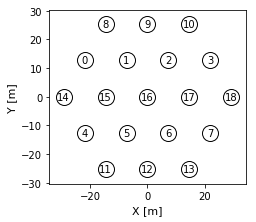

In [15]:
case_id = case_with_HI.keys()[0]

fig, ax = PLT.subplots(1, 1, figsize=(3.5,3.5))
ax.plot(antlocs[:,0], antlocs[:,1], ls='none', marker='o', mec='black', mfc='none', ms=16, color='black')

for antind,antlabel in enumerate(antlabels):
    ax.annotate(antlabel, (antlocs[antind,0], antlocs[antind,1]), xycoords='data', ha='center', va='center', color='black')
    
ax.set_xlim(NP.min(antlocs[:,0])-5, NP.max(antlocs[:,0])+5)
ax.set_ylim(NP.min(antlocs[:,1])-5, NP.max(antlocs[:,1])+5)
ax.set_aspect('equal')
ax.set_xlabel('E [m]', fontsize=11, weight='medium')
ax.set_ylabel('N [m]', fontsize=11, weight='medium')

fig.subplots_adjust(left=0.2, right=0.98, bottom=0.12, top=0.98)

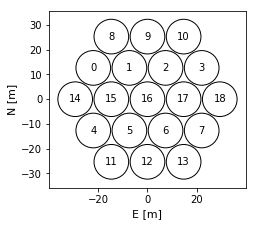

In [66]:
case_id = case_with_HI.keys()[0]

fig, ax = PLT.subplots(1, 1, figsize=(3.5,3.5))

for antind,antlabel in enumerate(antlabels):
    ax.add_patch(Circle((antlocs[antind,0], antlocs[antind,1]), radius=0.5*case_with_HI[case_id]['vis'].telescope['size'], color='none', ec='black', lw=1))
    ax.annotate(antlabel, (antlocs[antind,0], antlocs[antind,1]), xycoords='data', ha='center', va='center', color='black')
    
ax.set_xlim(NP.min(antlocs[:,0])-0.75*case_with_HI[case_id]['vis'].telescope['size'], NP.max(antlocs[:,0])+0.75*case_with_HI[case_id]['vis'].telescope['size'])
ax.set_ylim(NP.min(antlocs[:,1])-0.75*case_with_HI[case_id]['vis'].telescope['size'], NP.max(antlocs[:,1])+0.75*case_with_HI[case_id]['vis'].telescope['size'])
ax.set_aspect('equal')
ax.set_xlabel('E [m]', fontsize=11, weight='medium')
ax.set_ylabel('N [m]', fontsize=11, weight='medium')

fig.subplots_adjust(left=0.2, right=0.98, bottom=0.12, top=0.98)

PLT.savefig(figdir+'HERA-19_antenna_layout.pdf', bbox_inches=0)

## Compute closure phases of cases with Foregrounds and HI

In [16]:
cpinfo_case_with_FG_HI = {}
for case_id in case_with_FG_HI:
    print('Computing closure phases on unique triads for {0}...'.format(case_id))
    cpinfo_case_with_FG_HI[case_id] = case_with_FG_HI[case_id]['vis'].getClosurePhase(unique=True)

Computing closure phases on unique triads for 1ps_FG_no_spindex_HI_colocated...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for 1ps_FG_spindex_HI_displaced...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for 1ps_FG_spindex_HI_21cmfast...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for 1ps_FG_spindex_HI_colocated...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for GLEAM_1ps_HI...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for 1ps_FG_no_spindex_HI_21cmfast...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for 1ps_FG_no_spindex_HI_displaced...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for GLEAM_HI_21cmfast...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


## Compute closure phases of cases with Foregrounds only

In [17]:
cpinfo_case_with_FG = {}
for case_id in case_with_FG:
    print('Computing closure phases on unique triads for {0}...'.format(case_id))
    cpinfo_case_with_FG[case_id] = case_with_FG[case_id]['vis'].getClosurePhase(unique=True)

Computing closure phases on unique triads for 1ps_FG_no_spindex_off_zenith...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for 1ps_FG_spindex_off_zenith...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for 1ps_FG_no_spindex_on_zenith...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for 1ps_FG_spindex_on_zenith...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for GLEAM...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


## Compute closure phases of cases with HI only

In [18]:
cpinfo_case_with_HI = {}
for case_id in case_with_HI:
    print('Computing closure phases on unique triads for {0}...'.format(case_id))
    cpinfo_case_with_HI[case_id] = case_with_HI[case_id]['vis'].getClosurePhase(unique=True)

Computing closure phases on unique triads for 1ps_HI_cosine...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


Computing closure phases on unique triads for HI_21cmfast_fiducial...


100% |-----------------------------------------| 162/162 Triplets Time: 0:00:00


## Predict values for closure phases

In [19]:
predicted_cpinfo_with_FG_HI = {}
for case_id in case_with_FG_HI:
    imag_ratio_triad = (cpinfo_case_with_HI[key_mapping_FG_HI[case_id]['HI']]['skyvis'] / cpinfo_case_with_FG[key_mapping_FG_HI[case_id]['FG']]['skyvis']).imag
    predicted_cpinfo_with_FG_HI[case_id] = {'imag_ratio_triad': imag_ratio_triad, 'sum_imag_ratio_triad': NP.sum(imag_ratio_triad, axis=1)}
    print('Predicted closure phases on unique triads for {0}...'.format(case_id))

Predicted closure phases on unique triads for 1ps_FG_no_spindex_HI_colocated...
Predicted closure phases on unique triads for 1ps_FG_spindex_HI_displaced...
Predicted closure phases on unique triads for 1ps_FG_spindex_HI_21cmfast...
Predicted closure phases on unique triads for 1ps_FG_spindex_HI_colocated...
Predicted closure phases on unique triads for GLEAM_1ps_HI...
Predicted closure phases on unique triads for 1ps_FG_no_spindex_HI_21cmfast...
Predicted closure phases on unique triads for 1ps_FG_no_spindex_HI_displaced...
Predicted closure phases on unique triads for GLEAM_HI_21cmfast...


In [20]:
print(imag_ratio_triad.shape)
print(NP.sum(imag_ratio_triad, axis=1).shape)
pprint.pprint(cpinfo_case_with_HI[key_mapping_FG_HI[case_id]['HI']]['antenna_triplets'])
pprint.pprint(cpinfo_case_with_HI[key_mapping_FG_HI[case_id]['HI']]['baseline_triplets'])

(162, 3, 1024, 2)
(162, 1024, 2)
[('0', '1', '2'),
 ('0', '1', '3'),
 ('0', '1', '4'),
 ('0', '1', '5'),
 ('0', '1', '6'),
 ('0', '1', '7'),
 ('0', '1', '8'),
 ('0', '1', '9'),
 ('0', '1', '10'),
 ('0', '1', '11'),
 ('0', '1', '12'),
 ('0', '1', '13'),
 ('0', '1', '16'),
 ('0', '1', '17'),
 ('0', '1', '18'),
 ('0', '2', '4'),
 ('0', '2', '5'),
 ('0', '2', '6'),
 ('0', '2', '7'),
 ('0', '2', '8'),
 ('0', '2', '9'),
 ('0', '2', '10'),
 ('0', '2', '11'),
 ('0', '2', '12'),
 ('0', '2', '13'),
 ('0', '2', '17'),
 ('0', '2', '18'),
 ('0', '3', '4'),
 ('0', '3', '5'),
 ('0', '3', '6'),
 ('0', '3', '7'),
 ('0', '3', '8'),
 ('0', '3', '9'),
 ('0', '3', '10'),
 ('0', '3', '11'),
 ('0', '3', '12'),
 ('0', '3', '13'),
 ('0', '3', '14'),
 ('0', '3', '18'),
 ('0', '4', '8'),
 ('0', '4', '9'),
 ('0', '4', '10'),
 ('0', '4', '11'),
 ('0', '4', '12'),
 ('0', '4', '13'),
 ('0', '4', '14'),
 ('0', '4', '16'),
 ('0', '4', '17'),
 ('0', '4', '18'),
 ('0', '5', '8'),
 ('0', '5', '9'),
 ('0', '5', '10'),
 ('

In [21]:
print(cpinfo_case_with_HI.keys())

['1ps_HI_cosine', 'HI_21cmfast_fiducial']


In [22]:
triad1_label = 'EQ14'
triad1 = ('0', '1', '8')
triad1_ind = cpinfo_case_with_HI[cpinfo_case_with_HI.keys()[0]]['antenna_triplets'].index(triad1)
triad1_baselines = cpinfo_case_with_HI[cpinfo_case_with_HI.keys()[0]]['baseline_triplets'][triad1_ind]
blind1 = []
for i in range(3):
    blind = NP.where(NP.sum(NP.abs(baselines - triad1_baselines[[i]]), axis=1) <= 0.1)[0]
    if blind.size == 1:
        blind1 += [blind[0]]
    if blind.size == 0:
        blind = NP.where(NP.sum(NP.abs(baselines + triad1_baselines[[i]]), axis=1) <= 0.1)[0]
        if blind.size == 1:
            blind1 += [blind[0]]
        else:
            raise ValueError('Baseline [{0[0]:.1f}, {0[1]:.1f}, {0[2]:.1f}] nor its conjugate found'.format(triad1_baselines[i]))
bltriplet1_in_sim = NP.asarray([baselines[blind1[i]] for i in range(3)])
print(triad1_ind)
print(triad1_baselines)
print(blind1)
print(bltriplet1_in_sim)

6
[[ 14.6         0.          0.       ]
 [ -7.3        12.6439709   0.       ]
 [ -7.3       -12.6439709   0.       ]]
[0, 2, 1]
[[ 14.6         0.          0.       ]
 [  7.3       -12.6439709  -0.       ]
 [  7.3        12.6439709  -0.       ]]


In [23]:
triad2_label = 'EQ50'
triad2 = ('8', '11', '18')
triad2_ind = cpinfo_case_with_HI[cpinfo_case_with_HI.keys()[0]]['antenna_triplets'].index(triad2)
triad2_baselines = cpinfo_case_with_HI[cpinfo_case_with_HI.keys()[0]]['baseline_triplets'][triad2_ind]
blind2 = []
for i in range(3):
    blind = NP.where(NP.sum(NP.abs(baselines - triad2_baselines[[i]]), axis=1) <= 0.1)[0]
    if blind.size == 1:
        blind2 += [blind[0]]
    if blind.size == 0:
        blind = NP.where(NP.sum(NP.abs(baselines + triad2_baselines[[i]]), axis=1) <= 0.1)[0]
        if blind.size == 1:
            blind2 += [blind[0]]
        else:
            raise ValueError('Baseline [{0[0]:.1f}, {0[1]:.1f}, {0[2]:.1f}] nor its conjugate found'.format(triad2_baselines[i]))
bltriplet2_in_sim = NP.asarray([baselines[blind2[i]] for i in range(3)])
print(triad2_ind)
print(triad2_baselines)
print(blind2)
print(bltriplet2_in_sim)

143
[[  0.         -50.57588358   0.        ]
 [ 43.8         25.28794179  -0.        ]
 [-43.8         25.28794179  -0.        ]]
[19, 18, 20]
[[ -0.          50.57588358  -0.        ]
 [ 43.8         25.28794179  -0.        ]
 [ 43.8        -25.28794179   0.        ]]


In [24]:
print(triad1_ind)
print(triad1)
print(freqs.shape)
print(predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'].shape)
print(cpinfo_case_with_FG_HI[case_id]['closure_phase_skyvis'].shape)
print(cpinfo_case_with_FG[key_mapping_FG_HI[case_id]['FG']]['closure_phase_skyvis'].shape)
print(predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'].shape)
print((cpinfo_case_with_FG_HI[case_id]['closure_phase_skyvis'] - cpinfo_case_with_FG[key_mapping_FG_HI[case_id]['FG']]['closure_phase_skyvis'] - predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad']).shape)

6
('0', '1', '8')
(1024,)
(162, 3, 1024, 2)
(162, 1024, 2)
(162, 1024, 2)
(162, 1024, 2)
(162, 1024, 2)


In [25]:
print(figdir + 'closure_phase_comparison_actual_vs_prediction_HERA-19_triad_{0[0]}-{0[1]}-{0[2]}_chromatic_AiryBeam.pdf'.format(triad1))

/lustre/aoc/projects/hera/nthyagar/data/HERA/IDR2.1/ClosurePhase/models/bispectrum_phase/figures/closure_phase_comparison_actual_vs_prediction_HERA-19_triad_0-1-8_chromatic_AiryBeam.pdf


## Plot HI visibility amplitudes

	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)


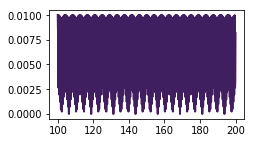

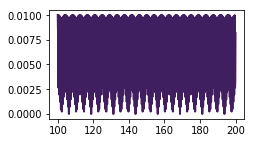

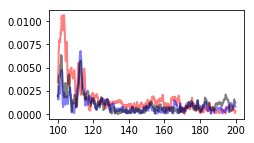

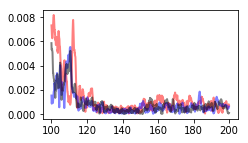

In [26]:
colrs = ['red', 'blue', 'black']
for case_id in case_with_HI:
    for blind, triad_ind, triad, triad_label in zip([blind1, blind2], [triad1_ind, triad2_ind], [triad1, triad2], [triad1_label, triad2_label]):
        print('\tPlotting Triad:({0[0]},{0[1]},{0[2]})'.format(triad))
        
        fig = PLT.figure(figsize=(3.5,2))
        ax = fig.add_subplot(111)
        for i in range(3):
            ax.plot(freqs/1e6, NP.abs(case_with_HI[case_id]['vis'].skyvis_freq[blind[i],:,0]), color=colrs[i], ls='-', lw=2, alpha=0.5)

## Plot: Plot Foreground and fluctuations in amplitude due to HI

Plotting 1ps_FG_no_spindex_HI_colocated:
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
Plotting 1ps_FG_spindex_HI_displaced:
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
Plotting 1ps_FG_spindex_HI_21cmfast:
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
Plotting 1ps_FG_spindex_HI_colocated:
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
Plotting GLEAM_1ps_HI:
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
Plotting 1ps_FG_no_spindex_HI_21cmfast:
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
Plotting 1ps_FG_no_spindex_HI_displaced:
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
Plotting GLEAM_HI_21cmfast:
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)


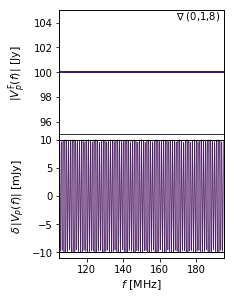

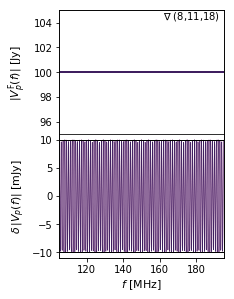

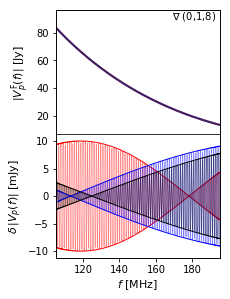

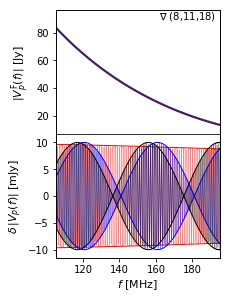

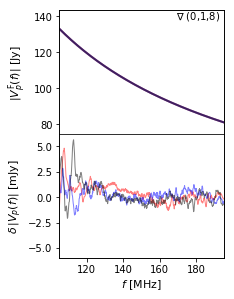

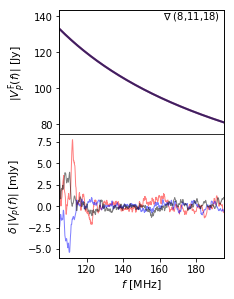

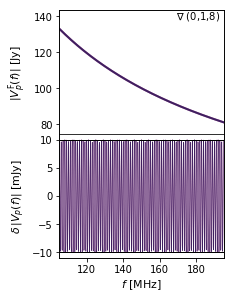

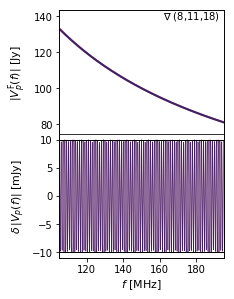

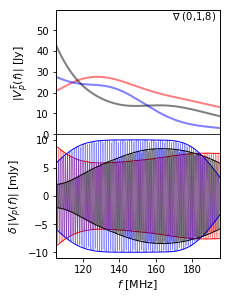

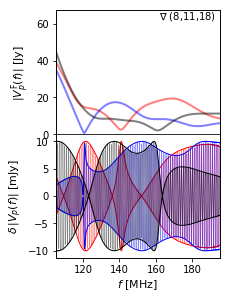

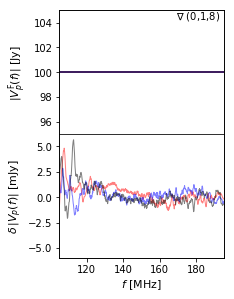

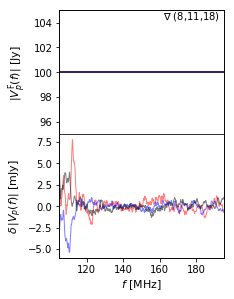

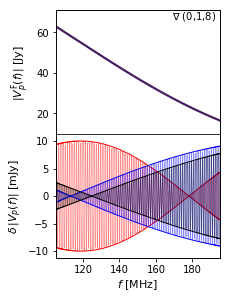

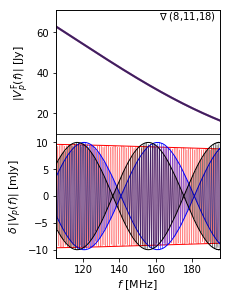

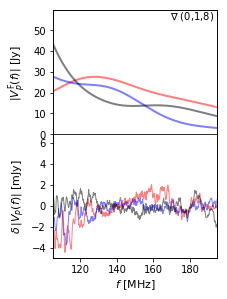

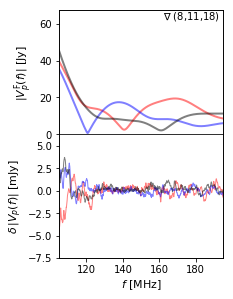

In [27]:
colrs = ['red', 'blue', 'black']
for case_id in case_with_FG_HI:
    if (('GLEAM' in case_id) or ('21cmfast' in case_id)) and ('cosine' not in key_mapping_FG_HI[case_id]['HI']):
        lwidth = 1
        plot_envelope = False
    else:
        lwidth = 0.5
        plot_envelope = True
    print('Plotting {0}:'.format(case_id))
    
    for blind, triad_ind, triad, triad_label in zip([blind1, blind2], [triad1_ind, triad2_ind], [triad1, triad2], [triad1_label, triad2_label]):
        print('\tPlotting Triad:({0[0]},{0[1]},{0[2]})'.format(triad))
        
        fig, axs = PLT.subplots(nrows=2, sharex=True, squeeze=True, figsize=(3,4))
        
        for i in range(3):
            axs[0].plot(freqs/1e6, NP.abs(case_with_FG[key_mapping_FG_HI[case_id]['FG']]['vis'].skyvis_freq[blind[i],:,0]), color=colrs[i], ls='-', lw=2, alpha=0.5)
            axs[1].plot(freqs/1e6, 1e3 * (NP.abs(case_with_FG_HI[case_id]['vis'].skyvis_freq[blind[i],:,0]) - NP.abs(case_with_FG[key_mapping_FG_HI[case_id]['FG']]['vis'].skyvis_freq[blind[i],:,0])), color=colrs[i], ls='-', lw=lwidth, alpha=0.5)
            if plot_envelope:
                axs[1].plot(freqs/1e6, 1e3 * (NP.abs(SPS.hilbert(NP.abs(case_with_FG_HI[case_id]['vis'].skyvis_freq[blind[i],:,0]) - NP.abs(case_with_FG[key_mapping_FG_HI[case_id]['FG']]['vis'].skyvis_freq[blind[i],:,0])))), color=colrs[i], ls='-', lw=1)
                axs[1].plot(freqs/1e6, -1e3 * (NP.abs(SPS.hilbert(NP.abs(case_with_FG_HI[case_id]['vis'].skyvis_freq[blind[i],:,0]) - NP.abs(case_with_FG[key_mapping_FG_HI[case_id]['FG']]['vis'].skyvis_freq[blind[i],:,0])))), color=colrs[i], ls='-', lw=1)            
            
        axs[0].text(0.98, 0.95, r'$\nabla$'+' ({0[0]},{0[1]},{0[2]})'.format(triad), transform=axs[0].transAxes, ha='right', va='center')
        axs[0].set_ylabel(r'$|V_p^\mathrm{F}(f)|$ [Jy]', fontsize=11, weight='medium')
        axs[1].set_ylabel(r'$\delta\,|V_p(f)|$ [mJy]', fontsize=11, weight='medium')
        
        axs[0].set_xlim(105, 195)
        axs[1].set_xlim(105, 195)

        ax0_ymin = NP.min(NP.abs(case_with_FG[key_mapping_FG_HI[case_id]['FG']]['vis'].skyvis_freq[blind,:,0]))
        ax0_ymax = NP.max(NP.abs(case_with_FG[key_mapping_FG_HI[case_id]['FG']]['vis'].skyvis_freq[blind,:,0]))
        axs[0].set_ylim(max([0, ax0_ymin-5]), ax0_ymax+5)
        
        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.22, right=0.98, bottom=0.12, top=0.98)
        
        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none')
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$f$ [MHz]', weight='medium', fontsize=11, labelpad=20)
        
        PLT.savefig(figdir + '{0}_visibility_models_{1}_HERA-19_chromatic_AiryBeam.pdf'.format(triad_label, case_id), bbox_inches=0)

## Plot: Compare computed and predicted values for closure phases

------------------------
Plotting 1ps_FG_no_spindex_HI_colocated
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_spindex_HI_displaced
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_spindex_HI_21cmfast
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_spindex_HI_colocated
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting GLEAM_1ps_HI
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_no_spindex_HI_21cmfast
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_no_spindex_HI_displaced
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting GLEAM_HI_21cmfast
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)


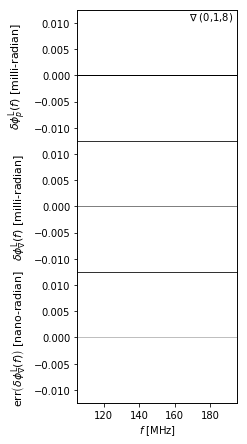

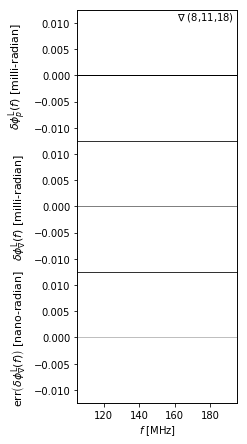

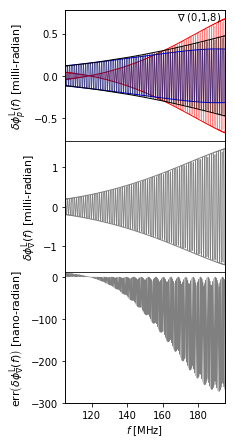

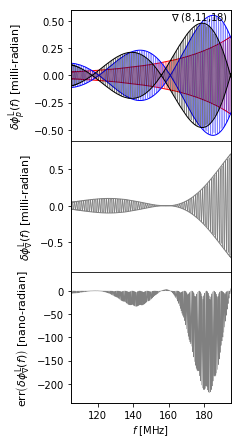

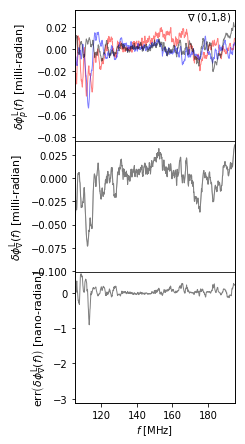

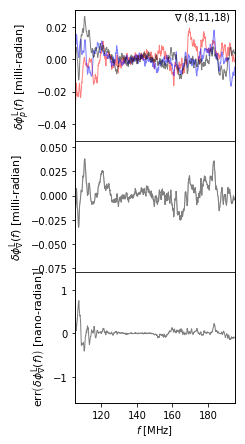

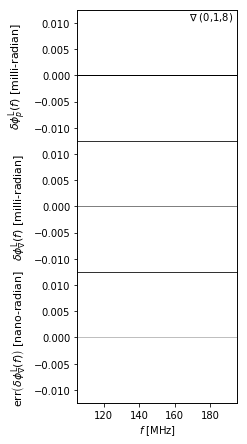

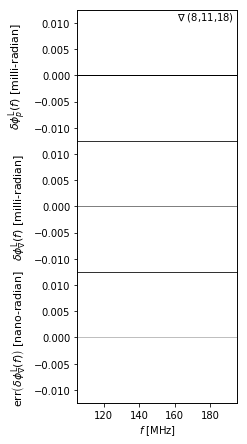

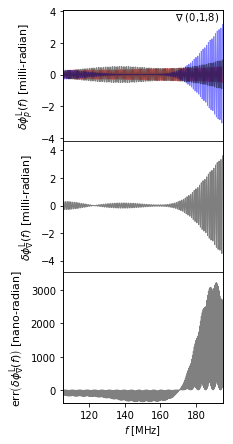

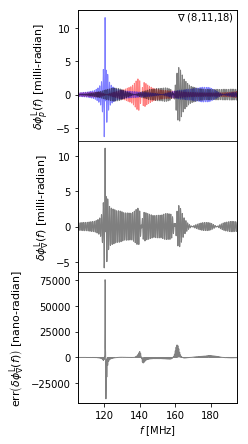

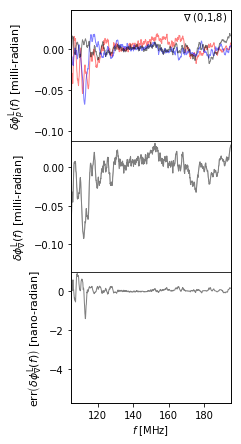

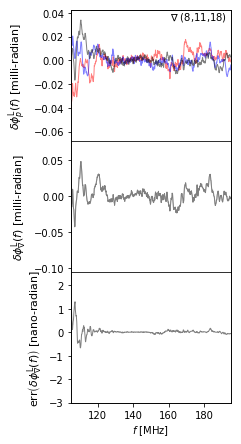

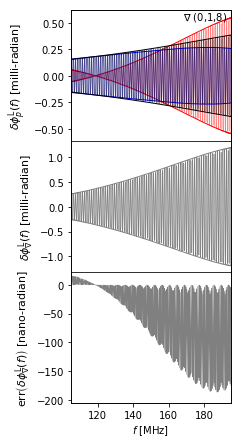

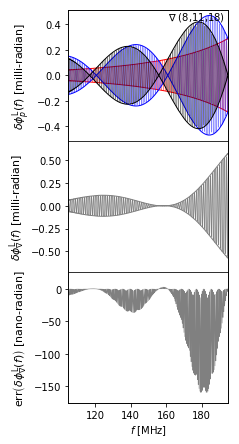

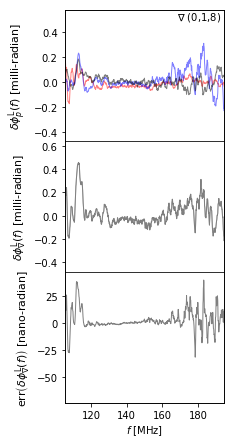

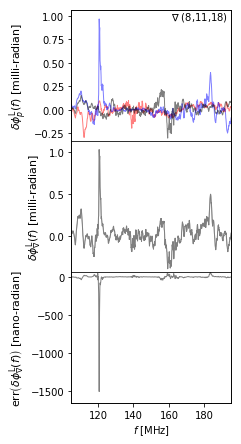

In [28]:
for case_id in case_with_FG_HI:
    print('------------------------\nPlotting {0}'.format(case_id))
    if ('GLEAM' in case_id) or ('21cmfast' in case_id):
        lwidth = 1
        plot_envelope = False
    else:
        lwidth = 0.5
        plot_envelope = True
    
    for triad_ind, triad, triad_label in zip([triad1_ind, triad2_ind], [triad1, triad2], [triad1_label, triad2_label]):
        print('\tPlotting Triad:({0[0]},{0[1]},{0[2]})'.format(triad))
        
        fig, axs = PLT.subplots(nrows=3, sharex=True, squeeze=True, figsize=(3,6))

        colrs = ['red', 'blue', 'black']
        for i in range(3):
            axs[0].plot(freqs/1e6, 1e3 * predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,i,:,0], ls='-', lw=lwidth, color=colrs[i], alpha=0.5)
            if plot_envelope:
                axs[0].plot(freqs/1e6, 1e3 * NP.abs(SPS.hilbert(predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,i,:,0])), ls='-', lw=1, color=colrs[i])
                axs[0].plot(freqs/1e6, -1e3 * NP.abs(SPS.hilbert(predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,i,:,0])), ls='-', lw=1, color=colrs[i])

        axs[0].text(0.98, 0.95, r'$\nabla$'+' ({0[0]},{0[1]},{0[2]})'.format(triad), transform=axs[0].transAxes, ha='right', va='center')
        axs[0].set_ylabel(r'$\delta\phi_p^\mathrm{L}(f)$ [milli-radian]', fontsize=11, weight='medium')
        axs[0].set_xlim(105, 195)
        ax0_ymin = 1e3 * NP.abs(NP.min(predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,:,:,0]))
        ax0_ymax = 1e3 * NP.abs(NP.max(predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,:,:,0]))
        axs[0].set_ylim(min([-0.0125, -1.1*ax0_ymin]), max([0.0125, 1.1*ax0_ymax]))

        axs[1].plot(freqs/1e6, 1e3 * (cpinfo_case_with_FG_HI[case_id]['closure_phase_skyvis'][triad_ind,:,0] - cpinfo_case_with_FG[key_mapping_FG_HI[case_id]['FG']]['closure_phase_skyvis'][triad_ind,:,0]), ls='-', lw=lwidth, color='black', alpha=0.5)
        axs[1].plot(freqs/1e6, 1e3 * predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0], ls='-', lw=lwidth, color='gray', alpha=0.5)
        if plot_envelope:
            axs[1].plot(freqs/1e6, 1e3 * NP.abs(SPS.hilbert(predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0])), ls='-', lw=1, color='gray')
            axs[1].plot(freqs/1e6, -1e3 * NP.abs(SPS.hilbert(predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0])), ls='-', lw=1, color='gray')
        axs[1].set_ylabel(r'$\delta\phi_\nabla^\mathrm{L}(f)$ [milli-radian]', fontsize=11, weight='medium')
        axs[1].set_xlim(105, 195)
        ax1_ymin = 1e3 * NP.abs(NP.min(predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0]))
        ax1_ymax = 1e3 * NP.abs(NP.max(predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0]))
        axs[1].set_ylim(min([-0.0125, -1.1*ax1_ymin]), max([0.0125, 1.1*ax1_ymax]))

        axs[2].plot(freqs/1e6, 1e9 * (cpinfo_case_with_FG_HI[case_id]['closure_phase_skyvis'][triad_ind,:,0] - cpinfo_case_with_FG[key_mapping_FG_HI[case_id]['FG']]['closure_phase_skyvis'][triad_ind,:,0] - predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0]), ls='-', lw=lwidth, color='gray')
        axs[2].set_ylabel(r'err$\left(\delta\phi_\nabla^\mathrm{L}(f)\right)$ [nano-radian]', fontsize=11, weight='medium')
        axs[2].set_xlim(105, 195)
        ax2_ymin = 1e9 * NP.abs(NP.min(cpinfo_case_with_FG_HI[case_id]['closure_phase_skyvis'][triad_ind,:,0] - cpinfo_case_with_FG[key_mapping_FG_HI[case_id]['FG']]['closure_phase_skyvis'][triad_ind,:,0] - predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0]))
        ax2_ymax = 1e9 * NP.abs(NP.max(cpinfo_case_with_FG_HI[case_id]['closure_phase_skyvis'][triad_ind,:,0] - cpinfo_case_with_FG[key_mapping_FG_HI[case_id]['FG']]['closure_phase_skyvis'][triad_ind,:,0] - predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0]))
        axs[2].set_ylim(min([-0.0125, -1.1*ax2_ymin]), max([0.0125, 1.1*ax2_ymax]))

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.24, right=0.98, bottom=0.07, top=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none')
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$f$ [MHz]', weight='medium', labelpad=20)

        PLT.savefig(figdir + '{0}_closure_phase_comparison_actual_vs_prediction_{1}_HERA-19_chromatic_AiryBeam.pdf'.format(triad_label, case_id), bbox_inches=0)

## Plot baseline phase and bispectrum phase fluctuations

------------------------
Plotting 1ps_FG_no_spindex_HI_colocated
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_spindex_HI_displaced
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_spindex_HI_21cmfast
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_spindex_HI_colocated
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting GLEAM_1ps_HI
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_no_spindex_HI_21cmfast
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting 1ps_FG_no_spindex_HI_displaced
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)
------------------------
Plotting GLEAM_HI_21cmfast
	Plotting Triad:(0,1,8)
	Plotting Triad:(8,11,18)


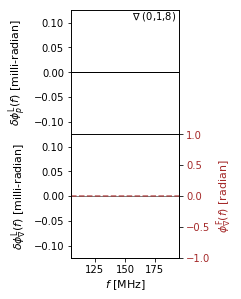

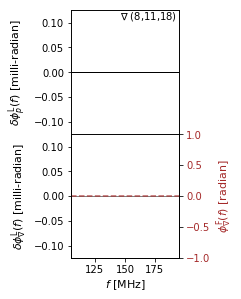

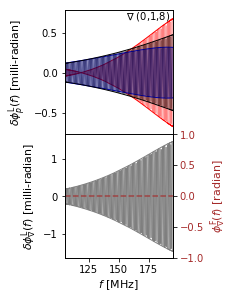

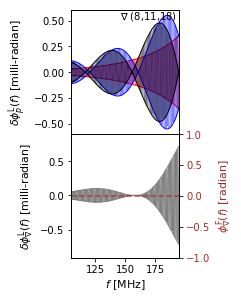

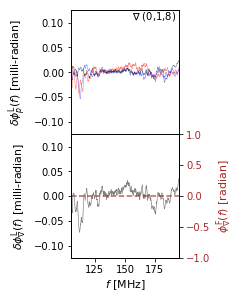

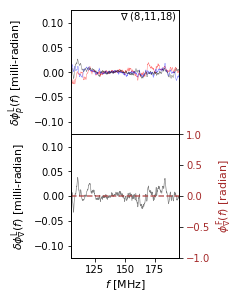

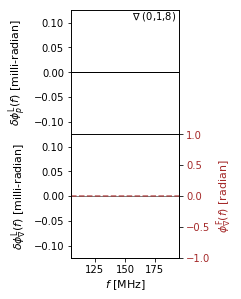

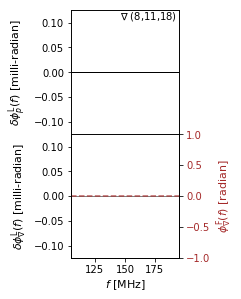

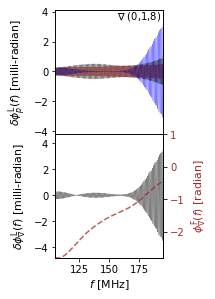

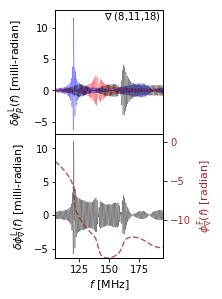

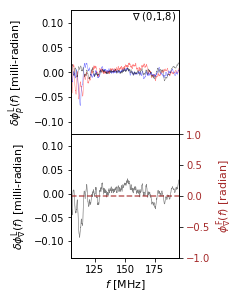

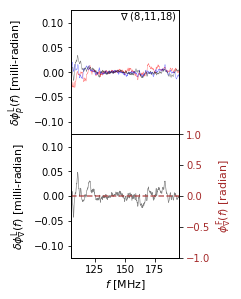

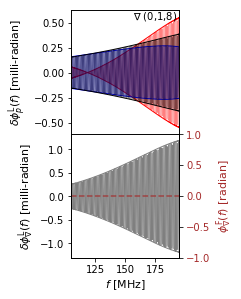

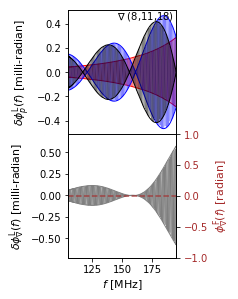

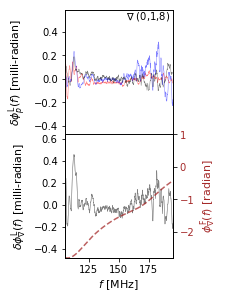

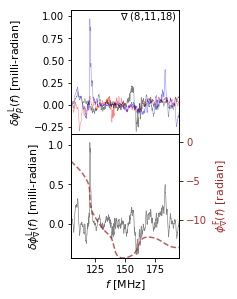

In [29]:
for case_id in case_with_FG_HI:
    print('------------------------\nPlotting {0}'.format(case_id))
    lwidth = 0.5
    if ('GLEAM' in case_id) or ('21cmfast' in case_id):
        plot_envelope = False
    else:
        plot_envelope = True
    
    for triad_ind, triad, triad_label in zip([triad1_ind, triad2_ind], [triad1, triad2], [triad1_label, triad2_label]):
        print('\tPlotting Triad:({0[0]},{0[1]},{0[2]})'.format(triad))
        
        fig, axs = PLT.subplots(nrows=2, sharex=True, squeeze=True, figsize=(3,4))

        colrs = ['red', 'blue', 'black']
        for i in range(3):
            axs[0].plot(freqs/1e6, 1e3 * predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,i,:,0], ls='-', lw=lwidth, color=colrs[i], alpha=0.5)
            if plot_envelope:
                axs[0].plot(freqs/1e6, 1e3 * NP.abs(SPS.hilbert(predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,i,:,0])), ls='-', lw=1, color=colrs[i])
                axs[0].plot(freqs/1e6, -1e3 * NP.abs(SPS.hilbert(predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,i,:,0])), ls='-', lw=1, color=colrs[i])

        axs[0].text(0.98, 0.95, r'$\nabla$'+' ({0[0]},{0[1]},{0[2]})'.format(triad), transform=axs[0].transAxes, ha='right', va='center')
        axs[0].set_ylabel(r'$\delta\phi_p^\mathrm{L}(f)$ [milli-radian]', fontsize=11, weight='medium')
        axs[0].set_xlim(105, 195)
        ax0_ymin = 1e3 * NP.abs(NP.min(predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,:,:,0]))
        ax0_ymax = 1e3 * NP.abs(NP.max(predicted_cpinfo_with_FG_HI[case_id]['imag_ratio_triad'][triad_ind,:,:,0]))
        axs[0].set_ylim(min([-0.125, -1.1*ax0_ymin]), max([0.125, 1.1*ax0_ymax]))

        axs[1].plot(freqs/1e6, 1e3 * (cpinfo_case_with_FG_HI[case_id]['closure_phase_skyvis'][triad_ind,:,0] - cpinfo_case_with_FG[key_mapping_FG_HI[case_id]['FG']]['closure_phase_skyvis'][triad_ind,:,0]), ls='-', lw=lwidth, color='black', alpha=0.5)
        axs[1].plot(freqs/1e6, 1e3 * predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0], ls='-', lw=lwidth, color='gray', alpha=0.5)
        if plot_envelope:
            axs[1].plot(freqs/1e6, 1e3 * NP.abs(SPS.hilbert(predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0])), ls='-', lw=1, color='gray')
            axs[1].plot(freqs/1e6, -1e3 * NP.abs(SPS.hilbert(predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0])), ls='-', lw=1, color='gray')
        axs[1].set_ylabel(r'$\delta\phi_\nabla^\mathrm{L}(f)$ [milli-radian]', fontsize=11, weight='medium')
        axs[1].set_xlim(105, 195)
        ax1_ymin = 1e3 * NP.abs(NP.min(predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0]))
        ax1_ymax = 1e3 * NP.abs(NP.max(predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,0]))
        axs[1].set_ylim(min([-0.125, -1.1*ax1_ymin]), max([0.125, 1.1*ax1_ymax]))
        
        bsp_fg_unwrap = NP.unwrap(cpinfo_case_with_FG[key_mapping_FG_HI[case_id]['FG']]['closure_phase_skyvis'][triad_ind,:,0])
        ax1r = axs[1].twinx()
        ax1r.plot(freqs/1e6, bsp_fg_unwrap, ls='--', lw=1.5, color='brown', alpha=0.75)
#         ax1r.set_ylim(min([-0.1,NP.min(bsp_fg_unwrap)]), max([0.1,NP.max(bsp_fg_unwrap)]))
        ax1r.set_ylim(min([-1,NP.min(bsp_fg_unwrap)]), max([1,NP.max(bsp_fg_unwrap)]))
        ax1r.set_ylabel(r'$\phi_\nabla^\mathrm{F}(f)$ [radian]', fontsize=11, weight='medium', color='brown')  # already handled the x-label with axs[1]
        ax1r.tick_params(axis='y', labelcolor='brown')

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.27, right=0.77, bottom=0.12, top=0.98)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none')
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$f$ [MHz]', fontsize=11, weight='medium', labelpad=20)
        
#         PLT.tight_layout(pad=0.01, w_pad=0.01, h_pad=0.01)
        
        PLT.savefig(figdir + '{0}_baseline_and_closure_phase_fluctuations_{1}_HERA-19_chromatic_AiryBeam.pdf'.format(triad_label, case_id), bbox_inches=0)

## Initialize delay spectrum objects for simulated visibilities

In [30]:
simDSobjs_FG = {}
simDSobjs_HI = {}
simDSobjs_FG_HI = {}

for case_id in case_with_FG:
    simDSobjs_FG[case_id] = DS.DelaySpectrum(interferometer_array=case_with_FG[case_id]['vis'])
for case_id in case_with_HI:
    simDSobjs_HI[case_id] = DS.DelaySpectrum(interferometer_array=case_with_HI[case_id]['vis'])
for case_id in case_with_FG_HI:
    simDSobjs_FG_HI[case_id] = DS.DelaySpectrum(interferometer_array=case_with_FG_HI[case_id]['vis'])

## Compute standard delay spectra for simulated visibilities in subbands

In [31]:
print('Foregrounds only\n================')
for case_id in case_with_FG:
    print('Computing standard subband delay transform for case "{0}"-----------------'.format(case_id))
    dspec = simDSobjs_FG[case_id].delay_transform(action='store')
    simDSobjs_FG[case_id].subband_delay_transform({key: freq_window_bw for key in ['cc', 'sim']}, 
                                                  freq_center={key: freq_window_centers for key in ['cc', 'sim']}, 
                                                  shape={key: freq_window_shape for key in ['cc', 'sim']}, 
                                                  fftpow={key: freq_window_fftpow for key in ['cc', 'sim']}, 
                                                  pad={key: pad for key in ['cc', 'sim']}, 
                                                  bpcorrect=False, action=None)
    print('-----------------')

Foregrounds only
Computing standard subband delay transform for case "1ps_FG_no_spindex_off_zenith"-----------------
Preparing to compute delay transform...
	Checking input parameters for compatibility...
	Frequency window weights assigned.
	Input parameters have been verified to be compatible.
	Proceeding to compute delay transform.
	Delay transform computed with padding fraction 1.0
	Delay transform products downsampled by factor of 2.0
delay_transform() completed successfully.
	Renormalized the shaping window to unit power.
	Sub-band(s) delay transform computed
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/scipy/signal/signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/scipy/signal/signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/scipy/signal/signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional i

Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
	Downsampled Sub-band(s) delay transform computed
-----------------
Computing standard subband delay transform for case "1ps_FG_spindex_off_zenith"-----------------
Preparing to compute delay transform...
	Checking input parameters for compatibility...
	Frequency window weights assigned.
	Input parameters have been verified to be compatible.
	Proceeding to compute delay transform.
	Delay transform computed with padding fraction 1.0
	Delay transform products downsampled by factor of 2.0
delay_transform() completed successfully.
	Renormalized the shaping window to unit power.
	Sub-band(s) delay transform computed
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
	Downsample

In [32]:
print('HI only\n=======')
for case_id in case_with_HI:
    print('Computing standard subband delay transform for case "{0}"-----------------'.format(case_id))
    dspec = simDSobjs_HI[case_id].delay_transform(action='store')
    simDSobjs_HI[case_id].subband_delay_transform({key: freq_window_bw for key in ['cc', 'sim']}, 
                                                  freq_center={key: freq_window_centers for key in ['cc', 'sim']}, 
                                                  shape={key: freq_window_shape for key in ['cc', 'sim']}, 
                                                  fftpow={key: freq_window_fftpow for key in ['cc', 'sim']}, 
                                                  pad={key: pad for key in ['cc', 'sim']}, 
                                                  bpcorrect=False, action=None)
    print('-----------------')

HI only
Computing standard subband delay transform for case "1ps_HI_cosine"-----------------
Preparing to compute delay transform...
	Checking input parameters for compatibility...
	Frequency window weights assigned.
	Input parameters have been verified to be compatible.
	Proceeding to compute delay transform.
	Delay transform computed with padding fraction 1.0
	Delay transform products downsampled by factor of 2.0
delay_transform() completed successfully.
	Renormalized the shaping window to unit power.
	Sub-band(s) delay transform computed
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
	Downsampled Sub-band(s) delay transform computed
-----------------
Computing standard subband delay transform for case "HI_21cmfast_fiducial"-----------------
Preparing to comput

In [33]:
print('Foregrounds + HI\n================')
for case_id in case_with_FG_HI:
    print('Computing standard subband delay transform for case "{0}"-----------------'.format(case_id))
    dspec = simDSobjs_FG_HI[case_id].delay_transform(action='store')
    simDSobjs_FG_HI[case_id].subband_delay_transform({key: freq_window_bw for key in ['cc', 'sim']}, 
                                                     freq_center={key: freq_window_centers for key in ['cc', 'sim']}, 
                                                     shape={key: freq_window_shape for key in ['cc', 'sim']}, 
                                                     fftpow={key: freq_window_fftpow for key in ['cc', 'sim']}, 
                                                     pad={key: pad for key in ['cc', 'sim']}, 
                                                     bpcorrect=False, action=None)
    print('-----------------')

Foregrounds + HI
Computing standard subband delay transform for case "1ps_FG_no_spindex_HI_colocated"-----------------
Preparing to compute delay transform...
	Checking input parameters for compatibility...
	Frequency window weights assigned.
	Input parameters have been verified to be compatible.
	Proceeding to compute delay transform.
	Delay transform computed with padding fraction 1.0
	Delay transform products downsampled by factor of 2.0
delay_transform() completed successfully.
	Renormalized the shaping window to unit power.
	Sub-band(s) delay transform computed
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
	Downsampled Sub-band(s) delay transform computed
-----------------
Computing standard subband delay transform for case "1ps_FG_spindex_HI_displaced"----

## Compute standard delay power spectra for simulated visibilities in subbands

In [34]:
simDPSobjs_FG = {}
simDPSobjs_HI = {}
simDPSobjs_FG_HI = {}

print('Foregrounds only\n================')
for case_id in case_with_FG:
    print('Initializing and computing standard subband delay power spectra for case "{0}"'.format(case_id))
    simDPSobjs_FG[case_id] = DS.DelayPowerSpectrum(simDSobjs_FG[case_id])
    simDPSobjs_FG[case_id].compute_power_spectrum()
    print('-----------------')
    
print('\nHI only\n=======')
for case_id in case_with_HI:
    print('Initializing and computing standard subband delay power spectra for case "{0}"'.format(case_id))
    simDPSobjs_HI[case_id] = DS.DelayPowerSpectrum(simDSobjs_HI[case_id])
    simDPSobjs_HI[case_id].compute_power_spectrum()
    print('-----------------')
    
print('\nForegrounds + HI\n================')
for case_id in case_with_FG_HI:
    print('Initializing and computing standard subband delay power spectra for case "{0}"'.format(case_id))
    simDPSobjs_FG_HI[case_id] = DS.DelayPowerSpectrum(simDSobjs_FG_HI[case_id])
    simDPSobjs_FG_HI[case_id].compute_power_spectrum()
    print('-----------------')

Foregrounds only
Initializing and computing standard subband delay power spectra for case "1ps_FG_no_spindex_off_zenith"
-----------------
Initializing and computing standard subband delay power spectra for case "1ps_FG_spindex_off_zenith"
-----------------
Initializing and computing standard subband delay power spectra for case "1ps_FG_no_spindex_on_zenith"
-----------------
Initializing and computing standard subband delay power spectra for case "1ps_FG_spindex_on_zenith"
-----------------
Initializing and computing standard subband delay power spectra for case "GLEAM"
-----------------

HI only
Initializing and computing standard subband delay power spectra for case "1ps_HI_cosine"
-----------------
Initializing and computing standard subband delay power spectra for case "HI_21cmfast_fiducial"
-----------------

Foregrounds + HI
Initializing and computing standard subband delay power spectra for case "1ps_FG_no_spindex_HI_colocated"
-----------------
Initializing and computing stand

In [35]:
print(simDPSobjs_FG_HI[simDPSobjs_FG_HI.keys()[0]].subband_delay_power_spectra['sim'].keys())
print(simDPSobjs_FG_HI[simDPSobjs_FG_HI.keys()[0]].subband_delay_power_spectra['sim']['horizon_kprll_limits'].shape)

['drz_los', 'kprll', 'kperp', 'jacobian2', 'rz_transverse', 'vis_lag', 'vis_noise_lag', 'dz', 'factor', 'skyvis_lag', 'horizon_kprll_limits', 'Jy2K', 'z', 'rz_los', 'jacobian1']
(2, 1, 30, 2)


## Initialize instances of class ClosurePhase (no approximation)

In [36]:
cpObjs_FG_HI = {}
cpObjs_FG = {}
for case_id in case_with_FG_HI:
    cpObjs_FG_HI[case_id] = {}
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG_HI[case_id][triad_label] = BSP.ClosurePhase(bspdir+triad_label+case_with_FG_HI[case_id]['bspfile_sfx'], 
                                                              freqs, infmt='hdf5')
for case_id in case_with_FG:
    cpObjs_FG[case_id] = {}
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG[case_id][triad_label] = BSP.ClosurePhase(bspdir+triad_label+case_with_FG[case_id]['bspfile_sfx'], 
                                                           freqs, infmt='hdf5')

In [37]:
pprint.pprint(cpObjs_FG_HI.keys())
print('-------------')
pprint.pprint(cpObjs_FG.keys())
print('-------------')
pprint.pprint(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo.keys())
print('-------------')
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['raw'].keys())
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['raw']['triads'].shape)
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['raw']['triads'])
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['raw']['days'].shape)
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['raw']['lst-day'].shape)
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['raw']['lst'].shape)
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['raw']['cphase'].shape)

['1ps_FG_spindex_HI_displaced',
 '1ps_FG_no_spindex_HI_displaced',
 'GLEAM_HI_21cmfast',
 '1ps_FG_no_spindex_HI_colocated',
 '1ps_FG_spindex_HI_colocated',
 'GLEAM_1ps_HI',
 '1ps_FG_spindex_HI_21cmfast',
 '1ps_FG_no_spindex_HI_21cmfast']
-------------
['1ps_FG_no_spindex_off_zenith',
 '1ps_FG_spindex_off_zenith',
 '1ps_FG_no_spindex_on_zenith',
 '1ps_FG_spindex_on_zenith',
 'GLEAM']
-------------
[u'raw', 'processed', 'errinfo']
-------------
[u'triads', u'cphase', u'days', u'lst-day', u'lst', u'flags']
(1, 3)
[['8' '11' '18']]
(4,)
(2, 4)
(2, 4)
(2, 4, 1, 1024)


## Initialize instances of class ClosurePhase predictions (from first order approximation)

In [38]:
cpObjs_FG_HI_predicted = copy.deepcopy(cpObjs_FG_HI) # Copy the object for convenience
for case_id in case_with_FG_HI:
    print('Working on creating closure phase objects with first-order predictions for case: {0}'.format(case_id))
    for triad_ind, triad_label in zip([triad1_ind, triad2_ind], [triad1_label, triad2_label]):
        print('\t{0}'.format(triad_label))
#         processed_dict = cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo.pop('processed', None) # Remove processed portions for recomputing
        cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['errinfo'] = {}
#         raw_cphase = cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['raw'].pop('cphase', None)
#         print(cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo.keys())
#         print(cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['raw'].keys())
        cp_fluctuations = predicted_cpinfo_with_FG_HI[case_id]['sum_imag_ratio_triad'][triad_ind,:,:].T[:,NP.newaxis,NP.newaxis,:] # (nchan, nlst) --> (nlst,ndays=1,ntriads=1,nchan)
        eicp_multiplicative_perturbations = (1 + 1j*cp_fluctuations) / NP.abs(1 + 1j*cp_fluctuations)
#         print(eicp_multiplicative_perturbations.shape)
        cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['native']['eicp'] = cpObjs_FG[key_mapping_FG_HI[case_id]['FG']][triad_label].cpinfo['processed']['native']['eicp'] * eicp_multiplicative_perturbations
        cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['native']['cphase'] = MA.angle(cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['native']['eicp'])
        cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['raw']['cphase'] = cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['native']['cphase'].data
#         cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['raw']['cphase'] = cpObjs_FG[key_mapping_FG_HI[case_id]['FG']][triad_label].cpinfo['raw']['cphase'] + cp_fluctuations # Add predicted fluctuations
#         cpObjs_FG_HI_predicted[case_id][triad_label].expicp(force_action=True) # Force the initial computations and population of the dictionary attributes
#         print(cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo.keys())
#         print(cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['raw'].keys())
#         print(cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed'].keys())
#         print(cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['native'].keys())
        print(cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['native']['cphase'].shape)
    print('-------------')

Working on creating closure phase objects with first-order predictions for case: 1ps_FG_no_spindex_HI_colocated
	EQ14
(2, 4, 1, 1024)
	EQ50
(2, 4, 1, 1024)
-------------
Working on creating closure phase objects with first-order predictions for case: 1ps_FG_spindex_HI_displaced
	EQ14
(2, 4, 1, 1024)
	EQ50
(2, 4, 1, 1024)
-------------
Working on creating closure phase objects with first-order predictions for case: 1ps_FG_spindex_HI_21cmfast
	EQ14
(2, 4, 1, 1024)
	EQ50
(2, 4, 1, 1024)
-------------
Working on creating closure phase objects with first-order predictions for case: 1ps_FG_spindex_HI_colocated
	EQ14
(2, 4, 1, 1024)
	EQ50
(2, 4, 1, 1024)
-------------
Working on creating closure phase objects with first-order predictions for case: GLEAM_1ps_HI
	EQ14
(2, 4, 1, 1024)
	EQ50
(2, 4, 1, 1024)
-------------
Working on creating closure phase objects with first-order predictions for case: 1ps_FG_no_spindex_HI_21cmfast
	EQ14
(2, 4, 1, 1024)
	EQ50
(2, 4, 1, 1024)
-------------
Working o

## Smooth in LST and days

In [39]:
daybinsize = None # days
ndaybins = 2
lstbinsize = 59.9 # seconds
print('day bin size = '+str(daybinsize), 'ndaybins={0:0d}'.format(ndaybins), 'LST bin size = {0:.1f}s'.format(lstbinsize))

for case_id in case_with_FG_HI:
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG_HI[case_id][triad_label].smooth_in_tbins(daybinsize=daybinsize, ndaybins=ndaybins, 
                                                           lstbinsize=lstbinsize)

for case_id in case_with_FG_HI:
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG_HI_predicted[case_id][triad_label].smooth_in_tbins(daybinsize=daybinsize, ndaybins=ndaybins, 
                                                                     lstbinsize=lstbinsize)
        # Force the closure phases and exp(i*cphase) to conform with predictions
        for stat in ['mean', 'median']:
            cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['prelim']['cphase'][stat] = cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['native']['cphase'][:,[0],:,:] * NP.ones(ndaybins).reshape(1,-1,1,1)
            cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['prelim']['eicp'][stat] = cpObjs_FG_HI_predicted[case_id][triad_label].cpinfo['processed']['native']['eicp'][:,[0],:,:] * NP.ones(ndaybins).reshape(1,-1,1,1)

for case_id in case_with_FG:
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG[case_id][triad_label].smooth_in_tbins(daybinsize=daybinsize, ndaybins=ndaybins, 
                                                        lstbinsize=lstbinsize)

('day bin size = None', 'ndaybins=2', 'LST bin size = 59.9s')


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/prisim/bispectrum_phase.py:1885: UserWarning: LST bin size found to be smaller than the LST resolution in the data. No LST binning/averaging will be performed.
  warnings.warn('LST bin size found to be smaller than the LST resolution in the data. No LST binning/averaging will be performed.')
/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [40]:
pprint.pprint(cpObjs_FG[case_id][triad_label].cpinfo['processed'].keys())
print('--------------')
print(cpObjs_FG[case_id][triad_label].cpinfo['processed']['prelim'].keys())
print(cpObjs_FG[case_id][triad_label].cpinfo['processed']['prelim']['cphase'].keys())
print(cpObjs_FG[case_id][triad_label].cpinfo['processed']['prelim']['lstbins'].shape)
print(cpObjs_FG[case_id][triad_label].cpinfo['processed']['prelim']['lstbins'])
print(cpObjs_FG[case_id][triad_label].cpinfo['processed']['prelim']['daybins'].shape)
print(cpObjs_FG[case_id][triad_label].cpinfo['processed']['prelim']['daybins'])
print(cpObjs_FG[case_id][triad_label].cpinfo['processed']['prelim']['cphase']['median'].shape)
print(cpObjs_FG[case_id][triad_label].cpinfo['processed']['prelim']['eicp']['median'].shape)

['prelim', 'native']
--------------
['cphase', 'wts', 'eicp', 'dlstbins', 'daybins', 'diff_dbins', 'lstbins']
['rms', 'median', 'mad', 'mean']
(2,)
[5.55625446 5.57296676]
(2,)
[2458446. 2458448.]
(2, 2, 1, 1024)
(2, 2, 1, 1024)


## Subtract a model of Closure Phase (optional)
### Creates new keys 'submodel' and 'residual' with a key-value structure similar to 'prelim'

In [41]:
for case_id in case_with_FG_HI:
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG_HI[case_id][triad_label].subtract(NP.zeros(1024))

for case_id in case_with_FG_HI:
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG_HI_predicted[case_id][triad_label].subtract(NP.zeros(1024))

for case_id in case_with_FG:
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG[case_id][triad_label].subtract(NP.zeros(1024))

print(cpObjs_FG[case_id][triad_label].cpinfo['processed'].keys())

['prelim', 'residual', 'submodel', 'native']


## Create subsample differences to keep track of noise from the noisy data

In [42]:
# ndaybins=4
print('ndaybins={0:0d}'.format(4), 'LST bin size = {0:.1f}s'.format(lstbinsize))

for case_id in case_with_FG_HI:
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG_HI[case_id][triad_label].subsample_differencing(daybinsize=None, ndaybins=4, 
                                                                  lstbinsize=lstbinsize)

for case_id in case_with_FG_HI:
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG_HI_predicted[case_id][triad_label].subsample_differencing(daybinsize=None, ndaybins=4, 
                                                                            lstbinsize=lstbinsize)

for case_id in case_with_FG:
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpObjs_FG[case_id][triad_label].subsample_differencing(daybinsize=None, ndaybins=4, 
                                                               lstbinsize=lstbinsize)

('ndaybins=4', 'LST bin size = 59.9s')


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/prisim/bispectrum_phase.py:2157: UserWarning: LST bin size found to be smaller than the LST resolution in the data. No LST binning/averaging will be performed.
  warnings.warn('LST bin size found to be smaller than the LST resolution in the data. No LST binning/averaging will be performed.')
/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/prisim/bispectrum_phase.py:2245: RuntimeWarning: invalid value encountered in less_equal
  mask1 = self.cpinfo['errinfo']['wts']['1'] <= 0.0


In [43]:
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['errinfo'].keys())
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['errinfo']['daybins'].shape)
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['errinfo']['lstbins'].shape)
print(len(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['errinfo']['list_of_pair_of_pairs']))
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['errinfo']['list_of_pair_of_pairs'])
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['errinfo']['eicp_diff'].keys())
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['errinfo']['eicp_diff']['0'].keys())
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['errinfo']['eicp_diff']['0']['median'].shape)
print(cpObjs_FG[cpObjs_FG.keys()[0]][triad_label].cpinfo['errinfo']['eicp_diff']['1']['median'].shape)

['wts', 'eicp_diff', 'dlstbins', 'daybins', 'lstbins', 'list_of_pair_of_pairs', 'diff_dbins']
(4,)
(2,)
3
[[0, 1, 2, 3], [0, 2, 1, 3], [0, 3, 1, 2]]
['1', '0']
['median', 'mean']
(2, 3, 1, 1024)
(2, 3, 1, 1024)


## Create instances of class ClosurePhaseDelaySpectrum for each of the cases

In [44]:
cpDSobjs_FG = {}
cpDSobjs_FG_HI = {}
cpDSobjs_FG_HI_predicted = {}

for case_id in cpObjs_FG:
    cpDSobjs_FG[case_id] = {}
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpDSobjs_FG[case_id][triad_label] = BSP.ClosurePhaseDelaySpectrum(cpObjs_FG[case_id][triad_label])
        
for case_id in cpObjs_FG_HI:
    cpDSobjs_FG_HI[case_id] = {}
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpDSobjs_FG_HI[case_id][triad_label] = BSP.ClosurePhaseDelaySpectrum(cpObjs_FG_HI[case_id][triad_label])
        
for case_id in cpObjs_FG_HI_predicted:
    cpDSobjs_FG_HI_predicted[case_id] = {}
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        cpDSobjs_FG_HI_predicted[case_id][triad_label] = BSP.ClosurePhaseDelaySpectrum(cpObjs_FG_HI_predicted[case_id][triad_label])

## Prepare to compute delay spectrum of the ClosurePhaseDelaySpectrum instances

In [45]:
visscaleinfo_FG = {}
for case_id in cpObjs_FG:
    visscaleinfo_FG[case_id] = {}
    for triad_baselines, triad_label in zip([triad1_baselines, triad2_baselines], [triad1_label, triad2_label]):
        visscaleinfo_FG[case_id][triad_label] = {'vis': case_with_FG[case_id]['vis'], 
                                                 'bltriplet': triad_baselines, 
                                                 'smoothinfo': {'op_type': 'interp1d', 'interp_kind': 'linear'}
                                                }

In [46]:
pprint.pprint(visscaleinfo_FG[cpObjs_FG.keys()[0]])

{'EQ14': {'bltriplet': array([[ 14.6      ,   0.       ,   0.       ],
       [ -7.3      ,  12.6439709,   0.       ],
       [ -7.3      , -12.6439709,   0.       ]]),
          'smoothinfo': {'interp_kind': 'linear', 'op_type': 'interp1d'},
          'vis': <prisim.interferometry.InterferometerArray object at 0x7fb2a8260cd0>},
 'EQ50': {'bltriplet': array([[  0.        , -50.57588358,   0.        ],
       [ 43.8       ,  25.28794179,  -0.        ],
       [-43.8       ,  25.28794179,  -0.        ]]),
          'smoothinfo': {'interp_kind': 'linear', 'op_type': 'interp1d'},
          'vis': <prisim.interferometry.InterferometerArray object at 0x7fb2a8260cd0>}}


In [47]:
freq_window_centers = NP.asarray([150e6])
freq_window_bw = NP.asarray([42e6])
freq_window_shape = 'bhw'
freq_window_fftpow = 2
pad = 7.0

print('freq window centers = ', freq_window_centers)
print('freq window BW eff = ', freq_window_bw)
print('freq window shape = '+freq_window_shape)
print('freq window fftpow = {0:.1f}'.format(freq_window_fftpow))
print('pad = {0:.1f}'.format(pad))

('freq window centers = ', array([1.5e+08]))
('freq window BW eff = ', array([42000000.]))
freq window shape = bhw
freq window fftpow = 2.0
pad = 7.0


## Compute delay spectrum of the ClosurePhaseDelaySpectrum instance

### Foregrounds only

In [48]:
cpds_FG = {}

print('Foregrounds only\n================')
for case_id in cpDSobjs_FG:
    cpds_FG[case_id] = {}
    print('Computing delay spectrum for case: {0}'.format(case_id))
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        print('\t{0}'.format(triad_label))
        cpds_FG[case_id][triad_label] = cpDSobjs_FG[case_id][triad_label].FT(freq_window_bw, 
                                                                             freq_center=freq_window_centers, 
                                                                             shape=freq_window_shape, fftpow=freq_window_fftpow, 
                                                                             pad=pad, datapool='prelim', 
                                                                             visscaleinfo=visscaleinfo_FG[case_id][triad_label], 
                                                                             method='fft', resample=True, apply_flags=False)
    print('-------------')

Foregrounds only
Computing delay spectrum for case: 1ps_FG_no_spindex_off_zenith
	EQ14


/lustre/aoc/users/nthyagar/src/miniconda2/envs/PRISim-dev/lib/python2.7/site-packages/numpy/ma/core.py:2788: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
	EQ50
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data

### Foregrounds + HI (no approximation)

In [49]:
cpds_FG_HI = {}

print('Foregrounds + HI (No approximation)\n===================================')

for case_id in cpDSobjs_FG_HI:
    cpds_FG_HI[case_id] = {}
    print('Computing delay spectrum for case: {0}'.format(case_id))
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        print('\t{0}'.format(triad_label))
        cpds_FG_HI[case_id][triad_label] = cpDSobjs_FG_HI[case_id][triad_label].FT(freq_window_bw, 
                                                                                   freq_center=freq_window_centers, 
                                                                                   shape=freq_window_shape, 
                                                                                   fftpow=freq_window_fftpow, 
                                                                                   pad=pad, datapool='prelim', 
                                                                                   visscaleinfo=visscaleinfo_FG[key_mapping_FG_HI[case_id]['FG']][triad_label], 
                                                                                   method='fft', resample=True, apply_flags=False)
    print('-------------')

Foregrounds + HI (No approximation)
Computing delay spectrum for case: 1ps_FG_spindex_HI_displaced
	EQ14
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
	EQ50
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsam

	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
-------------


### Foregrounds + HI (predicted based on linear-order approximation)

In [50]:
cpds_FG_HI_predicted = {}

print('Foregrounds + HI (linear-order prediction)\n==========================================')

for case_id in cpDSobjs_FG_HI_predicted:
    cpds_FG_HI_predicted[case_id] = {}
    print('Computing delay spectrum for case: {0}'.format(case_id))
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        print('\t{0}'.format(triad_label))
        cpds_FG_HI_predicted[case_id][triad_label] = cpDSobjs_FG_HI_predicted[case_id][triad_label].FT(freq_window_bw, 
                                                                                                       freq_center=freq_window_centers, 
                                                                                                       shape=freq_window_shape, 
                                                                                                       fftpow=freq_window_fftpow, 
                                                                                                       pad=pad, datapool='prelim', 
                                                                                                       visscaleinfo=visscaleinfo_FG[key_mapping_FG_HI[case_id]['FG']][triad_label], 
                                                                                                       method='fft', resample=True, apply_flags=False)
    print('-------------')

Foregrounds + HI (linear-order prediction)
Computing delay spectrum for case: 1ps_FG_spindex_HI_displaced
	EQ14
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
	EQ50
	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the 

	Renormalized the shaping window to unit power.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Determining the interpolating function for downsampling.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
Returning the downsampled data.
-------------


In [51]:
print(cpDSobjs_FG_HI[cpDSobjs_FG_HI.keys()[0]][triad1_label].cPhaseDS['whole']['dspec']['mean'].shape)
print(NP.abs(cpDSobjs_FG_HI[cpDSobjs_FG_HI.keys()[0]][triad1_label].cPhaseDS['whole']['dspec']['mean']).max())

(1, 2, 2, 1, 8192)
897245359.2781259


In [52]:
cohax = None
incohax = [1, 2, 3] # LST, days, triads
collapseax = [1, 2, 3] # Collapse along diagonals of LST, days, triads

# lst_in_sim = case_with_FG[case_with_FG.keys()[0]]['vis'].lst
# lstinds = NP.arange(lst_in_sim.size)
# dayind = None
selection = {}
for triad,triad_label in zip([triad1, triad2], [triad1_label, triad2_label]):
    selection[triad_label] = None
#     selection[triad_label] = {'triads': triad, 'lst': lstinds, 'days': dayind}

In [53]:
print(selection)

{'EQ14': None, 'EQ50': None}


In [54]:
autoinfo = {'axes': cohax}
xinfo = {'axes': incohax, 'avgcov': False, 'collapse_axes': collapseax, 'dlst_range': [1.1]}

In [55]:
beaminfo = {'beamfile': None, 
            'filepathtype': 'default', 
            'filefmt': 'UVBeam', 
            'nside': 128, 
            'pol': 'X', 
            'chromatic': True, 
            'select_freq': 150e6, 
            'spec_interp': 'cubic', 
            'telescope': {'shape': 'delta', 
                          'size': 14.0, 
                          'orientation': [90.0, 270.0], 
                          'ocoords': 'altaz', 
                          'phased_array': False, 
                          'ground_plane': None
                         }
           }

In [56]:
xcpdps_FG = {}
print('Foregrounds only\n================')
for case_id in case_with_FG:
    xcpdps_FG[case_id] = {}
    print('Computing closure phase delay power spectrum for case: {0}'.format(case_id))
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        print('\t{0}'.format(triad_label))
        xcpdps_FG[case_id][triad_label] = cpDSobjs_FG[case_id][triad_label].compute_power_spectrum(selection=selection[triad_label], 
                                                                                                   autoinfo=autoinfo, 
                                                                                                   xinfo=xinfo, units='K', 
                                                                                                   beamparms=beaminfo)
    print('-------------')

Foregrounds only
Computing closure phase delay power spectrum for case: 1ps_FG_no_spindex_off_zenith
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_spindex_off_zenith
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_no_spindex_on_zenith
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_spindex_on_zenith
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: GLEAM
	EQ14
	EQ50
-------------


In [57]:
xcpdps_FG_HI = {}
print('Foregrounds + HI (No approximation)\n===================================')
for case_id in case_with_FG_HI:
    xcpdps_FG_HI[case_id] = {}
    print('Computing closure phase delay power spectrum for case: {0}'.format(case_id))
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        print('\t{0}'.format(triad_label))
        xcpdps_FG_HI[case_id][triad_label] = cpDSobjs_FG_HI[case_id][triad_label].compute_power_spectrum(selection=selection[triad_label], 
                                                                                                         autoinfo=autoinfo, xinfo=xinfo, 
                                                                                                         units='K', beamparms=beaminfo)
    print('-------------')

Foregrounds + HI (No approximation)
Computing closure phase delay power spectrum for case: 1ps_FG_no_spindex_HI_colocated
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_spindex_HI_displaced
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_spindex_HI_21cmfast
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_spindex_HI_colocated
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: GLEAM_1ps_HI
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_no_spindex_HI_21cmfast
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_no_spindex_HI_displaced
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: GLEAM_HI_21cmfast
	EQ14
	EQ50
-------------


In [58]:
xcpdps_FG_HI_predicted = {}
print('Foregrounds + HI (linear-order approximation)\n==============================================')
for case_id in case_with_FG_HI:
    xcpdps_FG_HI_predicted[case_id] = {}
    print('Computing closure phase delay power spectrum for case: {0}'.format(case_id))
    for triadi, triad_label in enumerate([triad1_label, triad2_label]):
        print('\t{0}'.format(triad_label))
        xcpdps_FG_HI_predicted[case_id][triad_label] = cpDSobjs_FG_HI_predicted[case_id][triad_label].compute_power_spectrum(selection=selection[triad_label], 
                                                                                                                             autoinfo=autoinfo, xinfo=xinfo, 
                                                                                                                             units='K', beamparms=beaminfo)
    print('-------------')

Foregrounds + HI (linear-order approximation)
Computing closure phase delay power spectrum for case: 1ps_FG_no_spindex_HI_colocated
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_spindex_HI_displaced
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_spindex_HI_21cmfast
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_spindex_HI_colocated
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: GLEAM_1ps_HI
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_no_spindex_HI_21cmfast
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: 1ps_FG_no_spindex_HI_displaced
	EQ14
	EQ50
-------------
Computing closure phase delay power spectrum for case: GLEAM_HI_21cmfast
	EQ14
	EQ50
-------------


In [59]:
print(xcpdps_FG_HI[xcpdps_FG_HI.keys()[0]][triad1_label].keys())
print(xcpdps_FG_HI[xcpdps_FG_HI.keys()[0]][triad1_label]['triads'])
print(xcpdps_FG_HI[xcpdps_FG_HI.keys()[0]][triad1_label]['oversampled'].keys())
print(xcpdps_FG_HI[xcpdps_FG_HI.keys()[0]][triad1_label]['oversampled']['whole'].keys())
print(xcpdps_FG_HI[xcpdps_FG_HI.keys()[0]][triad1_label]['oversampled']['whole']['mean'].shape)
print(xcpdps_FG_HI[xcpdps_FG_HI.keys()[0]][triad1_label]['oversampled']['whole']['diagoffsets'])

['triads', 'dday', 'triads_ind', 'lst', 'lstXoffsets', 'lst_ind', 'dlst', 'days', 'resampled', 'oversampled', 'day_ind']
[['0' '1' '8']]
['lags', 'residual', 'kprll', 'freq_wts', 'freq_center', 'bw_eff', 'shape', 'lag_corr_length', 'z', 'whole', 'submodel']
['axesmap', 'median', 'nsamples_coh', 'diagoffsets', 'nsamples_incoh', 'diagweights', 'mean']
(1, 2, 3, 1, 8192)
{1: array([0, 1]), 2: array([-1,  0,  1]), 3: array([0])}


Plotting deviations between actual and predicted closure phase power spectra
1ps_FG_no_spindex_HI_colocated:
	EQ14
	EQ50
-----------------
1ps_FG_spindex_HI_displaced:
	EQ14
	EQ50
-----------------
1ps_FG_spindex_HI_21cmfast:
	EQ14
	EQ50
-----------------
1ps_FG_spindex_HI_colocated:
	EQ14
	EQ50
-----------------
GLEAM_1ps_HI:
	EQ14
	EQ50
-----------------
1ps_FG_no_spindex_HI_21cmfast:
	EQ14
	EQ50
-----------------
1ps_FG_no_spindex_HI_displaced:
	EQ14
	EQ50
-----------------
GLEAM_HI_21cmfast:
	EQ14
	EQ50
-----------------


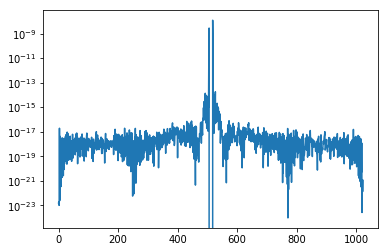

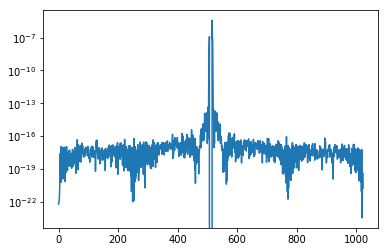

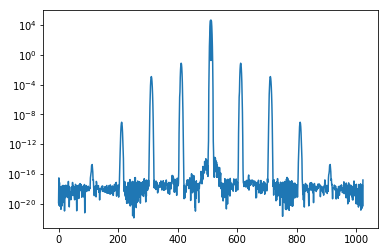

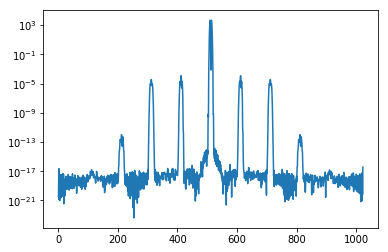

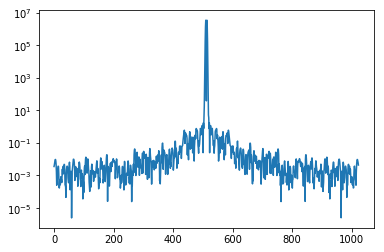

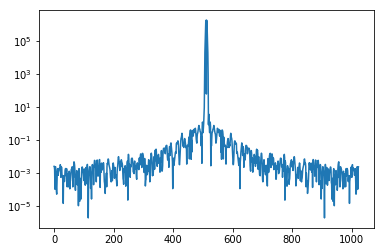

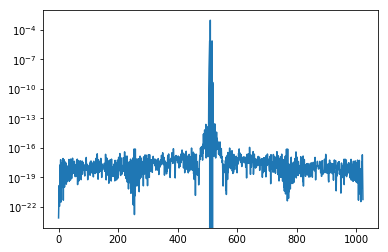

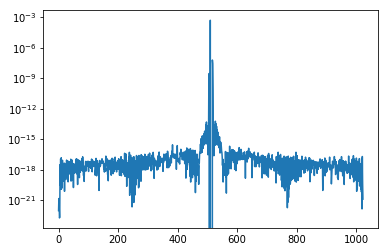

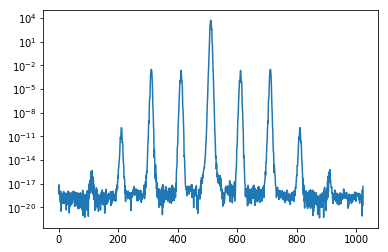

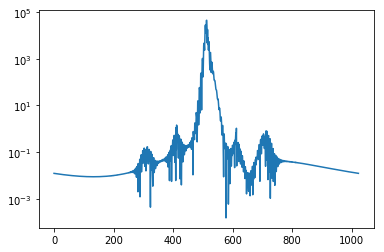

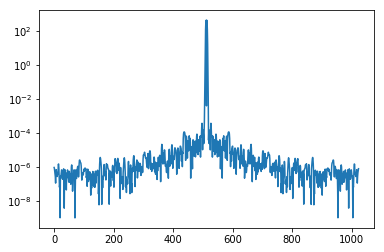

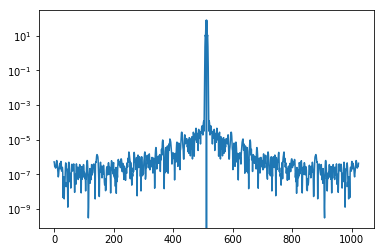

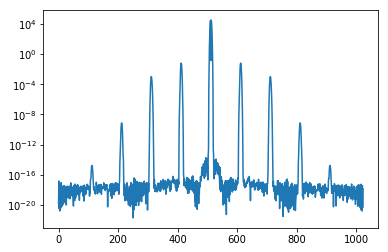

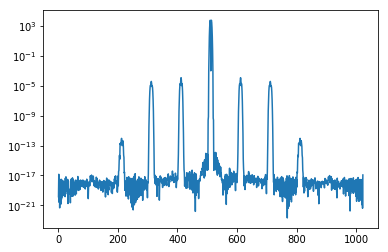

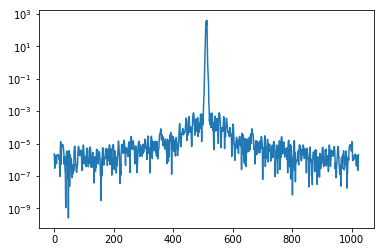

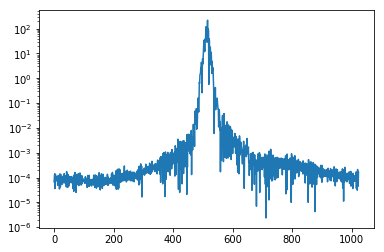

In [60]:
print('Plotting deviations between actual and predicted closure phase power spectra')
for case_id in case_with_FG_HI:
    print('{0}:'.format(case_id))
    for blind_triplet, triad_label in zip([blind1, blind2], [triad1_label, triad2_label]):
        print('\t{0}'.format(triad_label))
        prediction_deviation = NP.abs(xcpdps_FG_HI_predicted[case_id][triad_label]['oversampled']['whole']['mean'].real.to('mK2 Mpc3').value - xcpdps_FG_HI[case_id][triad_label]['oversampled']['whole']['mean'].real.to('mK2 Mpc3').value)
#         print(prediction_deviation.shape)
        fig = PLT.figure()
        ax = fig.add_subplot(111)
        ax.plot(prediction_deviation[0,0,1,0,::8])
        ax.set_yscale('log')
    print('-----------------')

In [61]:
# print(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind1,0])
# print(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind1,1])

## Plot standard and BSP delay spectra and for FG + HI cases as a function of $\tau$

Plotting standard delay spectrum for case "1ps_FG_no_spindex_HI_colocated" on triad "EQ14"
Plotting closure phase delay spectrum for case "1ps_FG_no_spindex_HI_colocated" on triad "EQ14"
Plotting standard delay spectrum for case "1ps_FG_spindex_HI_displaced" on triad "EQ14"
Plotting closure phase delay spectrum for case "1ps_FG_spindex_HI_displaced" on triad "EQ14"
Plotting standard delay spectrum for case "1ps_FG_spindex_HI_21cmfast" on triad "EQ14"
Plotting closure phase delay spectrum for case "1ps_FG_spindex_HI_21cmfast" on triad "EQ14"
Plotting standard delay spectrum for case "1ps_FG_spindex_HI_colocated" on triad "EQ14"
Plotting closure phase delay spectrum for case "1ps_FG_spindex_HI_colocated" on triad "EQ14"
Plotting standard delay spectrum for case "GLEAM_1ps_HI" on triad "EQ14"
Plotting closure phase delay spectrum for case "GLEAM_1ps_HI" on triad "EQ14"
Plotting standard delay spectrum for case "1ps_FG_no_spindex_HI_21cmfast" on triad "EQ14"
Plotting closure phase delay sp

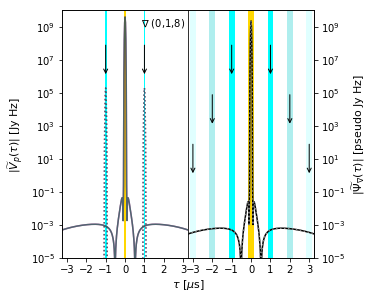

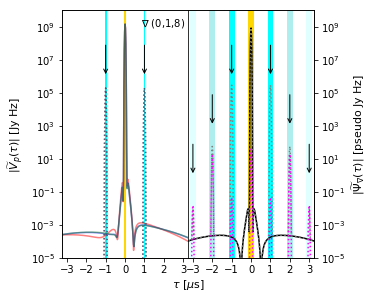

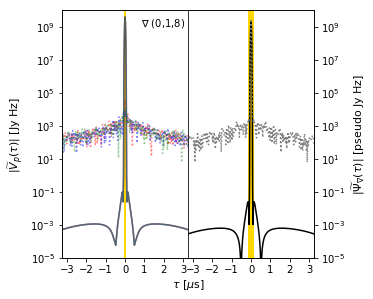

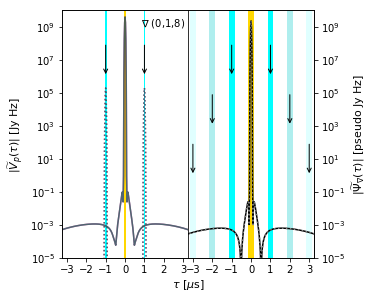

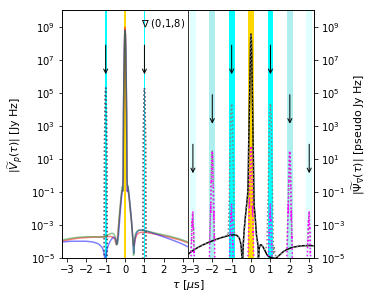

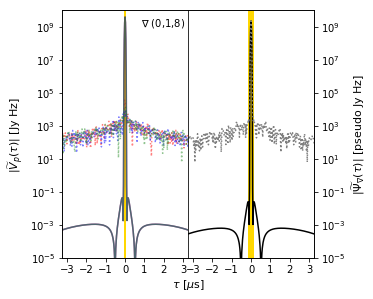

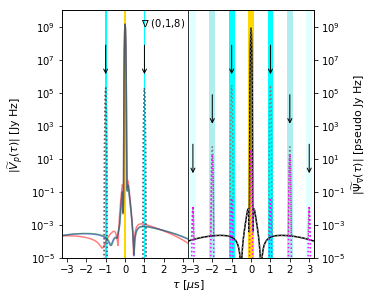

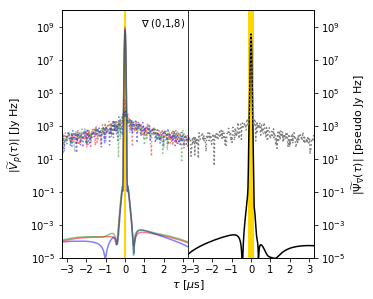

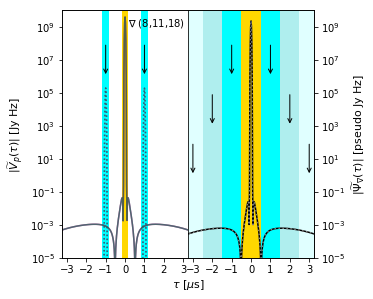

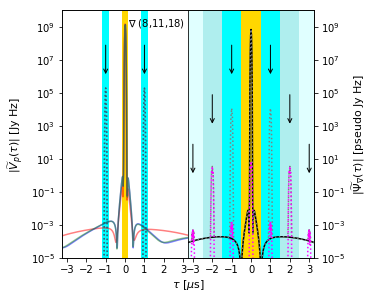

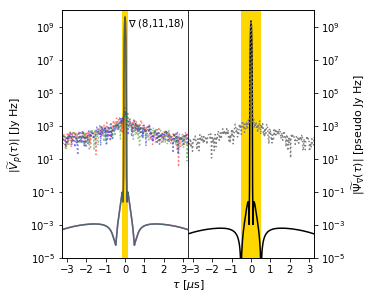

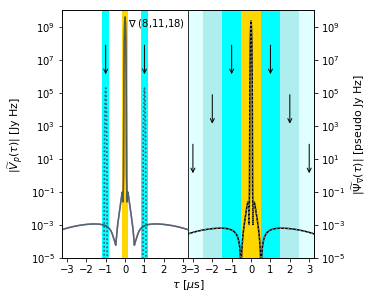

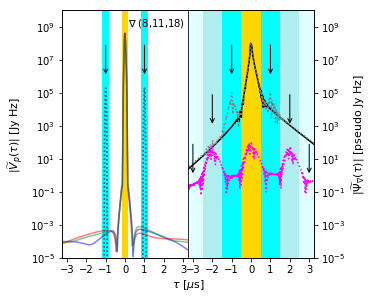

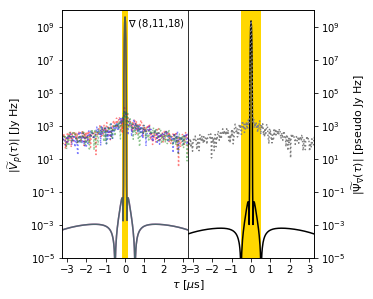

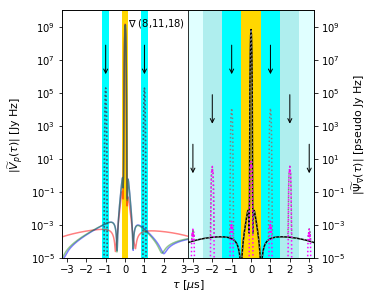

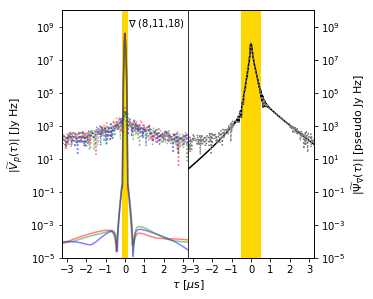

In [62]:
spw = [0]
lstind = 0
trind = 0
dayind = 0
delay_HI = 1e-6 # in seconds

colrs = ['red', 'blue', 'forestgreen']
harmonic_colrs = ['cyan', 'paleturquoise', 'lightcyan']

for spwind in spw:
    for blind_triplet, triad, triad_label in zip([blind1, blind2], [triad1, triad2], [triad1_label, triad2_label]):
        for case_id in case_with_FG_HI:
            print('Plotting standard delay spectrum for case "{0}" on triad "{1}"'.format(case_id, triad_label))
            fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, figsize=(5,4))

            axs[0].axvspan(1e6*NP.min(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,0]), 1e6*NP.max(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,1]), facecolor='gold')
            for blno, blind in enumerate(blind_triplet):
                axs[0].plot(1e6*simDSobjs_FG[key_mapping_FG_HI[case_id]['FG']].subband_delay_spectra['sim']['lags'][::16], NP.abs(simDSobjs_FG[key_mapping_FG_HI[case_id]['FG']].subband_delay_spectra['sim']['skyvis_lag'][blind,spwind,::16,lstind]), ls='-', color=colrs[blno], alpha=0.5)
                axs[0].plot(1e6*simDSobjs_HI[key_mapping_FG_HI[case_id]['HI']].subband_delay_spectra['sim']['lags'][::16], NP.abs(simDSobjs_HI[key_mapping_FG_HI[case_id]['HI']].subband_delay_spectra['sim']['skyvis_lag'][blind,spwind,::16,lstind]), ls=':', color=colrs[blno], alpha=0.5)

            if 'cosine' in key_mapping_FG_HI[case_id]['HI']:
                for i in range(1):
                    axs[0].axvspan(1e6*((i+1)*delay_HI + NP.min(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,0])), 1e6*((i+1)*delay_HI + NP.max(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,1])), facecolor=harmonic_colrs[i])
                    axs[0].axvspan(1e6*(-(i+1)*delay_HI + NP.min(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,0])), 1e6*(-(i+1)*delay_HI + NP.max(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,1])), facecolor=harmonic_colrs[i])
                    axs[0].annotate('', xy=(-(i+1), 1e6/(1e3)**i), xycoords='data', xytext=(-(i+1), 1e8/(1e3)**i), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)
                    axs[0].annotate('', xy=(i+1, 1e6/(1e3)**i), xycoords='data', xytext=(i+1, 1e8/(1e3)**i), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)

            axs[0].text(0.98, 0.95, r'$\nabla$'+' ({0[0]},{0[1]},{0[2]})'.format(triad), transform=axs[0].transAxes, ha='right', va='center')
            axs[0].set_yscale('log')
            axs[0].set_xticks(NP.arange(-5,6))
#             axs[0].tick_params(axis='x', rotation=45)
            axs[0].set_xlim(-3.25, 3.25)
            axs[0].set_ylim(1e-5, 1e10)
            axs[0].set_ylabel(r'$|\widetilde{V}_p(\tau)|$ [Jy Hz]', fontsize=11, weight='medium')
            
            print('Plotting closure phase delay spectrum for case "{0}" on triad "{1}"'.format(case_id, triad_label))
            cpds_lags = cpDSobjs_FG[key_mapping_FG_HI[case_id]['FG']][triad_label].cPhaseDS['lags']
            cpdsval_FG = cpDSobjs_FG[key_mapping_FG_HI[case_id]['FG']][triad_label].cPhaseDS['whole']['dspec']['mean'][spwind,lstind,dayind,trind,:]
            cpdsval_FG_HI = cpDSobjs_FG_HI[case_id][triad_label].cPhaseDS['whole']['dspec']['mean'][spwind,lstind,dayind,trind,:]
            cpdsval_FG_HI_predicted = cpDSobjs_FG_HI_predicted[case_id][triad_label].cPhaseDS['whole']['dspec']['mean'][spwind,lstind,dayind,trind,:]
            
            axs[1].axvspan(1e6*NP.sum(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,0]), 1e6*NP.sum(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,1]), facecolor='gold')
            axs[1].plot(1e6*cpDSobjs_FG[key_mapping_FG_HI[case_id]['FG']][triad_label].cPhaseDS['lags'][::16], NP.abs(cpdsval_FG[::16]), ls='-', color='black')
            axs[1].plot(1e6*cpDSobjs_FG_HI[case_id][triad_label].cPhaseDS['lags'][::16], NP.abs(cpdsval_FG_HI[::16]), ls=':', color='gray')
            if 'cosine' in key_mapping_FG_HI[case_id]['HI']:
                for i in range(3):
                    axs[1].axvspan(1e6*((i+1)*delay_HI + NP.sum(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,0])), 1e6*((i+1)*delay_HI + NP.sum(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,1])), facecolor=harmonic_colrs[i])
                    axs[1].axvspan(1e6*(-(i+1)*delay_HI + NP.sum(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,0])), 1e6*(-(i+1)*delay_HI + NP.sum(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,1])), facecolor=harmonic_colrs[i])
                    axs[1].annotate('', xy=(-(i+1)*delay_HI*1e6, 1e6/(1e3)**i), xycoords='data', xytext=(-(i+1)*delay_HI*1e6, 1e8/(1e3)**i), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)
                    axs[1].annotate('', xy=((i+1)*delay_HI*1e6, 1e6/(1e3)**i), xycoords='data', xytext=((i+1)*delay_HI*1e6, 1e8/(1e3)**i), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)
                axs[1].plot(1e6*cpDSobjs_FG_HI[case_id][triad_label].cPhaseDS['lags'][::1], NP.abs(cpdsval_FG_HI[::1] - cpdsval_FG_HI_predicted[::1]), ls=':', color='magenta')

            axs[1].yaxis.tick_right()
            axs[1].set_yscale('log')
            axs[1].set_xticks(NP.arange(-5,6))
#             axs[1].tick_params(axis='x', rotation=45)
            axs[1].set_xlim(-3.25, 3.25)
            axs[1].set_ylim(1e-5, 1e10)
            axs[1].set_ylabel(r'$|\widetilde{\Psi}_\nabla(\tau)|$ [pseudo Jy Hz]', fontsize=11, weight='medium')
            axs[1].yaxis.set_label_position('right')
            
            fig.subplots_adjust(hspace=0, wspace=0)
            fig.subplots_adjust(left=0.15, right=0.85, bottom=0.12, top=0.98)

            big_ax = fig.add_subplot(111)
            big_ax.set_facecolor('none')
            big_ax.set_xticks([])
            big_ax.set_yticks([])
            big_ax.set_xlabel(r'$\tau$ [$\mu$s]', fontsize=11, weight='medium', labelpad=20)

            PLT.savefig(figdir + '{0}_standard_vs_BSP_delay_spectra_{1}_HERA-19_chromatic_AiryBeam.pdf'.format(triad_label, case_id), bbox_inches=0)

## Plot showing the impact of spectral property of foregrounds (e.g. spectral index, $\alpha$)

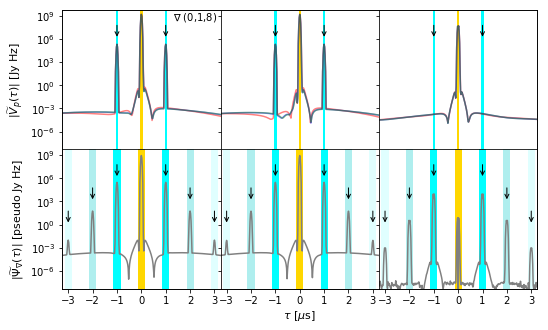

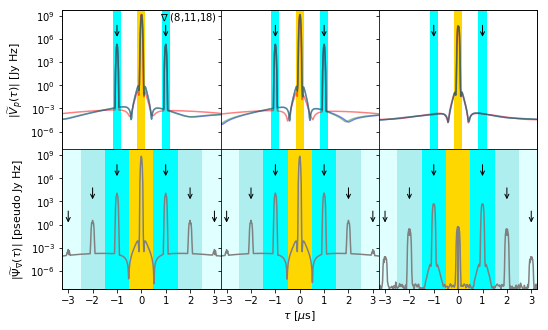

In [63]:
case_ids = ['1ps_FG_spindex_HI_displaced', '1ps_FG_no_spindex_HI_displaced']
spw = [0]
lstind = 0
trind = 0
dayind = 1
delay_HI = 1e-6 # in seconds

colrs = ['red', 'blue', 'forestgreen']
harmonic_colrs = ['cyan', 'paleturquoise', 'lightcyan']

ncols = 3
nrows = 2
for spwind in spw:
    for blind_triplet, triad, triad_label in zip([blind1, blind2], [triad1, triad2], [triad1_label, triad2_label]):
        simDS_vals = []
        cpds_vals = []
        for caseind, case_id in enumerate(case_ids):
            simDS_vals += [simDSobjs_FG_HI[case_id].subband_delay_spectra['sim']['skyvis_lag'][blind_triplet,spwind,:,lstind]]
            cpds_vals += [cpDSobjs_FG_HI[case_id][triad_label].cPhaseDS['whole']['dspec']['mean'][spwind,lstind,dayind,trind,:]]
        simDS_vals = NP.asarray(simDS_vals)
        cpds_vals = NP.asarray(cpds_vals)
        cpds0_argmax = NP.argmax(NP.abs(cpds_vals[0]))
        cpds_vals[1] = cpds_vals[1] * cpds_vals[0,cpds0_argmax] / cpds_vals[1,cpds0_argmax] # Re-normalize the peak of one case to the other

#         diff_simDS_vals = NP.sqrt(NP.abs(NP.diff(NP.abs(simDS_vals)**2, axis=0)))
#         diff_cpds_vals = NP.sqrt(NP.abs(NP.diff(NP.abs(cpds_vals)**2, axis=0)))

        diff_simDS_vals = NP.abs(NP.diff(simDS_vals, axis=0))
        diff_cpds_vals = NP.abs(NP.diff(cpds_vals, axis=0))
#         print(NP.argmax(NP.abs(diff_cpds_vals[0,cpds0_argmax-20:cpds0_argmax+20]))+cpds0_argmax-20)
#         print(NP.abs(diff_cpds_vals[0,cpds0_argmax-20:cpds0_argmax+20]))

#         print('Plotting standard delay spectrum for case "{0}" on triad "{1}"'.format(case_id, triad_label))
        fig, axs = PLT.subplots(nrows=nrows, ncols=ncols, squeeze=True, sharex=True, sharey=True, figsize=(7.5,4.5))
    
        for row in range(nrows):
            if row == 0:
                lags = simDSobjs_FG_HI[case_id].subband_delay_spectra['sim']['lags']
                horizon_lag_min = NP.min(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,0])
                horizon_lag_max = NP.max(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,1])
                dsvals = NP.concatenate((simDS_vals, diff_simDS_vals), axis=0)
            else:
                lags = cpDSobjs_FG_HI[case_id][triad_label].cPhaseDS['lags']
                horizon_lag_min = NP.sum(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,0])
                horizon_lag_max = NP.sum(simDSobjs_FG_HI[case_id].horizon_delay_limits[lstind,blind_triplet,1])
                dsvals = NP.concatenate((cpds_vals, diff_cpds_vals), axis=0)
            for col in range(ncols):
                axs[row,col].axvspan(1e6*horizon_lag_min, 1e6*horizon_lag_max, facecolor='gold')
                if row == 0:
                    for blno, blind in enumerate(blind_triplet): 
                        axs[row,col].plot(1e6*lags[::16], NP.abs(dsvals[col,blno,::16]), ls='-', color=colrs[blno], alpha=0.5)
                    for i in range(1):
                        axs[row,col].axvspan(1e6*((i+1)*delay_HI+horizon_lag_min), 1e6*((i+1)*delay_HI+horizon_lag_max), facecolor=harmonic_colrs[i])
                        axs[row,col].axvspan(1e6*(-(i+1)*delay_HI+horizon_lag_min), 1e6*(-(i+1)*delay_HI+horizon_lag_max), facecolor=harmonic_colrs[i])
                        axs[row,col].annotate('', xy=(-(i+1)*delay_HI*1e6, 1e6/(1e3)**i), xycoords='data', xytext=(-(i+1)*delay_HI*1e6, 1e8/(1e3)**i), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)
                        axs[row,col].annotate('', xy=((i+1)*delay_HI*1e6, 1e6/(1e3)**i), xycoords='data', xytext=((i+1)*delay_HI*1e6, 1e8/(1e3)**i), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)
                else:
                    axs[row,col].plot(1e6*lags[::16], NP.abs(dsvals[col,::16]), ls='-', color='gray')
                    for i in range(3):
                        axs[row,col].axvspan(1e6*((i+1)*delay_HI+horizon_lag_min), 1e6*((i+1)*delay_HI+horizon_lag_max), facecolor=harmonic_colrs[i])
                        axs[row,col].axvspan(1e6*(-(i+1)*delay_HI+horizon_lag_min), 1e6*(-(i+1)*delay_HI+horizon_lag_max), facecolor=harmonic_colrs[i])
                        axs[row,col].annotate('', xy=(-(i+1)*delay_HI*1e6, 1e6/(1e3)**i), xycoords='data', xytext=(-(i+1)*delay_HI*1e6, 1e8/(1e3)**i), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)
                        axs[row,col].annotate('', xy=((i+1)*delay_HI*1e6, 1e6/(1e3)**i), xycoords='data', xytext=((i+1)*delay_HI*1e6, 1e8/(1e3)**i), textcoords='data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),)

                axs[row,col].set_xticks(NP.arange(-5,6))
                axs[row,col].set_ylim(5e-9, 5e9)
                axs[row,col].set_yscale('log')
                axs[row,col].set_xlim(-3.25, 3.25)

        axs[0,0].set_ylabel(r'$|\widetilde{V}_p(\tau)|$ [Jy Hz]', fontsize=11, weight='medium')
        axs[1,0].set_ylabel(r'$|\widetilde{\Psi}_\nabla(\tau)|$ [pseudo Jy Hz]', fontsize=11, weight='medium')
        axs[0,0].text(0.98, 0.95, r'$\nabla$'+' ({0[0]},{0[1]},{0[2]})'.format(triad), transform=axs[0,0].transAxes, ha='right', va='center')

        fig.subplots_adjust(hspace=0, wspace=0)
        fig.subplots_adjust(left=0.1, right=0.98, bottom=0.1, top=0.96)

        big_ax = fig.add_subplot(111)
        big_ax.set_facecolor('none')
        big_ax.set_xticks([])
        big_ax.set_yticks([])
        big_ax.set_xlabel(r'$\tau$ [$\mu$s]', fontsize=11, weight='medium', labelpad=20)

        PLT.savefig(figdir + '{0}_spindex_effect_on_standard_vs_BSP_delay_spectra_1ps_FG_HI_displaced_HERA-19_chromatic_AiryBeam.pdf'.format(triad_label), bbox_inches=0)

## Plot standard and BSP delay power spectra and for FG + HI cases as a function of $k_\parallel$

Plotting standard delay spectrum for case "1ps_FG_no_spindex_HI_colocated" on triad "EQ14"
Plotting closure phase delay spectrum for case "1ps_FG_no_spindex_HI_colocated" on triad "EQ14"
Plotting standard delay spectrum for case "1ps_FG_spindex_HI_displaced" on triad "EQ14"
Plotting closure phase delay spectrum for case "1ps_FG_spindex_HI_displaced" on triad "EQ14"
Plotting standard delay spectrum for case "1ps_FG_spindex_HI_21cmfast" on triad "EQ14"
Plotting closure phase delay spectrum for case "1ps_FG_spindex_HI_21cmfast" on triad "EQ14"
Plotting standard delay spectrum for case "1ps_FG_spindex_HI_colocated" on triad "EQ14"
Plotting closure phase delay spectrum for case "1ps_FG_spindex_HI_colocated" on triad "EQ14"
Plotting standard delay spectrum for case "GLEAM_1ps_HI" on triad "EQ14"
Plotting closure phase delay spectrum for case "GLEAM_1ps_HI" on triad "EQ14"
Plotting standard delay spectrum for case "1ps_FG_no_spindex_HI_21cmfast" on triad "EQ14"
Plotting closure phase delay sp

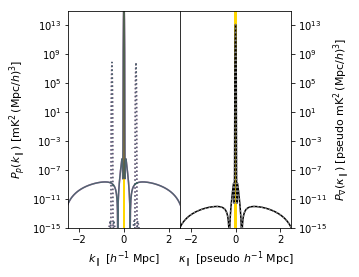

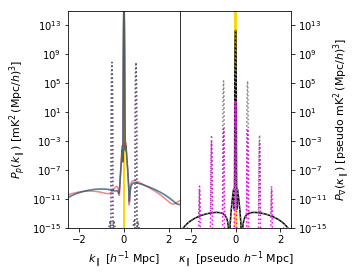

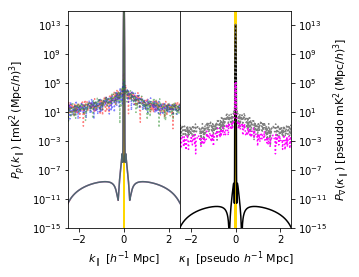

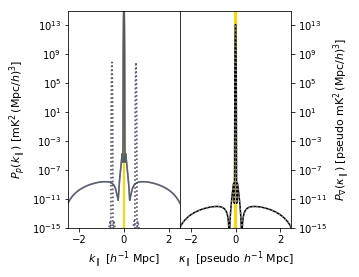

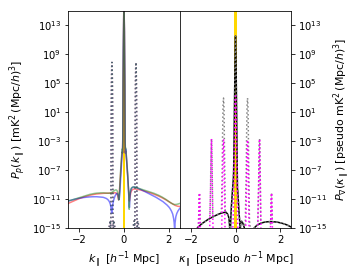

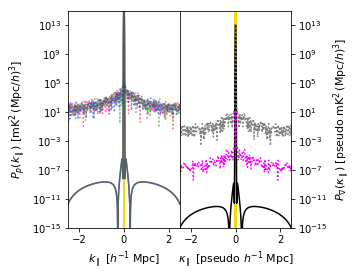

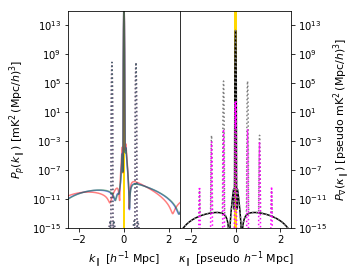

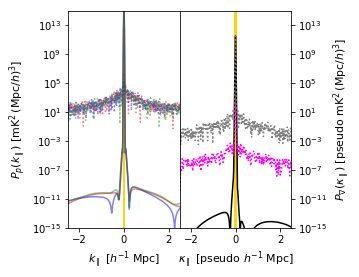

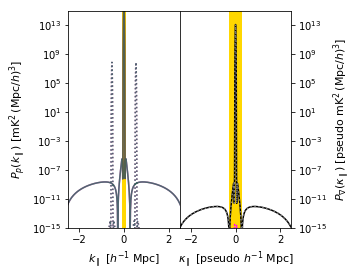

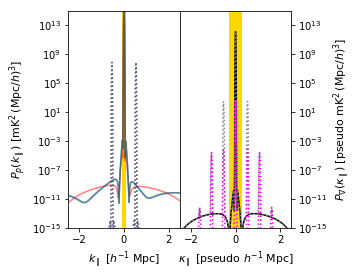

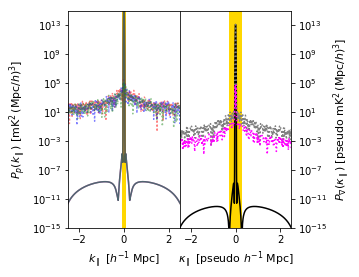

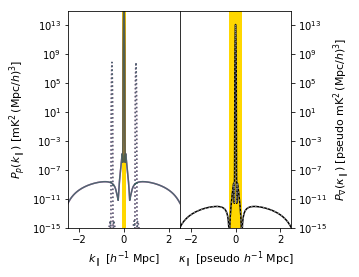

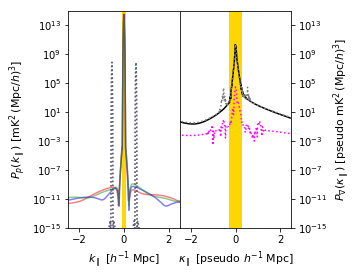

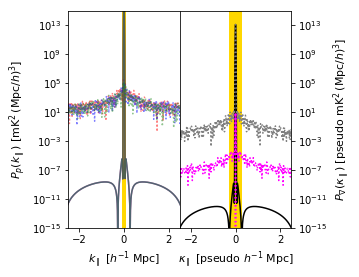

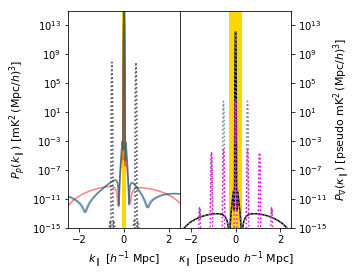

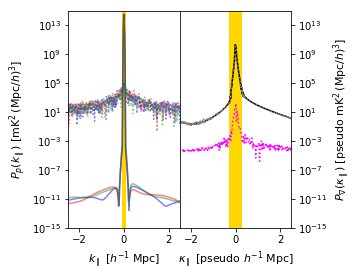

In [61]:
spw = [0]
lstind = 0
trind = 0
dayind = 1
colrs = ['red', 'blue', 'forestgreen']
for spwind in spw:
    for blind_triplet, triad_label in zip([blind1, blind2], [triad1_label, triad2_label]):
        for case_id in case_with_FG_HI:
            print('Plotting standard delay spectrum for case "{0}" on triad "{1}"'.format(case_id, triad_label))
            fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharex=True, figsize=(4,4))

            axs[0].axvspan(NP.min(simDPSobjs_FG_HI[case_id].subband_delay_power_spectra['sim']['horizon_kprll_limits'][lstind,spwind,blind_triplet,0]), NP.max(simDPSobjs_FG_HI[case_id].subband_delay_power_spectra['sim']['horizon_kprll_limits'][lstind,spwind,blind_triplet,1]), facecolor='gold')
            for blno, blind in enumerate(blind_triplet):
                axs[0].plot(simDPSobjs_FG[key_mapping_FG_HI[case_id]['FG']].subband_delay_power_spectra['sim']['kprll'][spwind,::16], 1e6*simDPSobjs_FG[key_mapping_FG_HI[case_id]['FG']].subband_delay_power_spectra['sim']['skyvis_lag'][blind,spwind,::16,lstind], ls='-', color=colrs[blno], alpha=0.5)
                axs[0].plot(simDPSobjs_HI[key_mapping_FG_HI[case_id]['HI']].subband_delay_power_spectra['sim']['kprll'][spwind,::16], 1e6*simDPSobjs_HI[key_mapping_FG_HI[case_id]['HI']].subband_delay_power_spectra['sim']['skyvis_lag'][blind,spwind,::16,lstind], ls=':', color=colrs[blno], alpha=0.5)

            axs[0].set_yscale('log')
            axs[0].set_xlim(-2.5, 2.5)
            axs[0].set_ylim(1e-15, 1e15)
            axs[0].set_xlabel(r'$k_\parallel$ [$h^{-1}$ Mpc]', fontsize=11, weight='medium')
            axs[0].set_ylabel(r'$P_p(k_\parallel)$ [mK$^2\,$(Mpc$/h$)$^3$]', fontsize=11, weight='medium')
            
            print('Plotting closure phase delay spectrum for case "{0}" on triad "{1}"'.format(case_id, triad_label))
            cpdpsval_FG = (2/3.0) * xcpdps_FG[key_mapping_FG_HI[case_id]['FG']][triad_label]['oversampled']['whole']['mean'][spwind,lstind,dayind,trind,:].real.to('mK2 Mpc3').value
            cpdpsval_FG_HI = (2/3.0) * xcpdps_FG_HI[case_id][triad_label]['oversampled']['whole']['mean'][spwind,lstind,dayind,trind,:].real.to('mK2 Mpc3').value
            cpdpsval_FG_HI_predicted = (2/3.0) * xcpdps_FG_HI_predicted[case_id][triad_label]['oversampled']['whole']['mean'][spwind,lstind,dayind,trind,:].real.to('mK2 Mpc3').value
            
            axs[1].axvspan(NP.sum(simDPSobjs_FG_HI[case_id].subband_delay_power_spectra['sim']['horizon_kprll_limits'][lstind,spwind,blind_triplet,0]), NP.sum(simDPSobjs_FG_HI[case_id].subband_delay_power_spectra['sim']['horizon_kprll_limits'][lstind,spwind,blind_triplet,1]), facecolor='gold')
            axs[1].plot(xcpdps_FG[key_mapping_FG_HI[case_id]['FG']][triad_label]['oversampled']['kprll'][spwind,::16], cpdpsval_FG[::16], ls='-', color='black')
#             axs[1].plot(xcpdps_FG_HI_predicted[case_id][triad_label]['oversampled']['kprll'][spwind,::16], cpdpsval_FG_HI_predicted[::16], ls=':', color='gray')
            axs[1].plot(xcpdps_FG_HI[case_id][triad_label]['oversampled']['kprll'][spwind,::16], cpdpsval_FG_HI[::16], ls=':', color='gray')
#             if 'cosine' in key_mapping_FG_HI[case_id]['HI']:
            axs[1].plot(xcpdps_FG_HI[case_id][triad_label]['oversampled']['kprll'][spwind,::32], NP.abs(cpdpsval_FG_HI[::32] - cpdpsval_FG_HI_predicted[::32]), ls=':', color='magenta')
#             print(xcpdps_FG_HI[case_id][triad_label]['oversampled']['kprll'][spwind,2000:3000:16])
#             print(cpdpsval_FG_HI[2312:2609] - cpdpsval_FG_HI_predicted[2312:2609])
#             print(NP.abs(cpdpsval_FG_HI[2312:2609] - cpdpsval_FG_HI_predicted[2312:2609]).max())
#             maxind = 2312 + NP.abs(cpdpsval_FG_HI[2312:2609] - cpdpsval_FG_HI_predicted[2312:2609]).argmax()
#             print(maxind)
#             print(cpdpsval_FG_HI[maxind], cpdpsval_FG_HI_predicted[maxind])
            axs[1].yaxis.tick_right()
            axs[1].set_yscale('log')
            axs[1].set_xlim(-2.5, 2.5)
            axs[1].set_ylim(1e-15, 1e15)
            axs[1].set_xlabel(r'$\kappa_\parallel$ [pseudo $h^{-1}$ Mpc]', fontsize=11, weight='medium')
            axs[1].set_ylabel(r'$P_\nabla(\kappa_\parallel)$ [pseudo mK$^2\,$(Mpc$/h$)$^3$]', fontsize=11, weight='medium')
            axs[1].yaxis.set_label_position('right')
            
            fig.subplots_adjust(hspace=0, wspace=0)


In [62]:
NP.where(NP.logical_and(xcpdps_FG_HI[case_id][triad_label]['oversampled']['kprll'][spwind,:]<-1.0, xcpdps_FG_HI[case_id][triad_label]['oversampled']['kprll'][spwind,:]>-1.2))

(array([2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322,
        2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333,
        2334, 2335, 2336, 2337, 2338, 2339, 2340, 2341, 2342, 2343, 2344,
        2345, 2346, 2347, 2348, 2349, 2350, 2351, 2352, 2353, 2354, 2355,
        2356, 2357, 2358, 2359, 2360, 2361, 2362, 2363, 2364, 2365, 2366,
        2367, 2368, 2369, 2370, 2371, 2372, 2373, 2374, 2375, 2376, 2377,
        2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 2387, 2388,
        2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399,
        2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410,
        2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421,
        2422, 2423, 2424, 2425, 2426, 2427, 2428, 2429, 2430, 2431, 2432,
        2433, 2434, 2435, 2436, 2437, 2438, 2439, 2440, 2441, 2442, 2443,
        2444, 2445, 2446, 2447, 2448, 2449, 2450, 2451, 2452, 2453, 2454,
        2455, 2456, 2457, 2458, 2459, 